# Preprocessing/EDA for Small area income estimates for middle layer super output areas, England & Wales, 2011/12

Dataset link: https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales

1.1 **Loading the dataset** from an .xlsx file to a Pandas DataFrame, then displaying the name of the sheets that have relevant information (i.e. variables/potential features)

In [1]:
import pandas as pd

# Defining the path for the raw and processed MSOA Income Estimate data
file_path = "../../data/raw/msoa_income.xlsx"
processed_path = "../../data/processed/" 

# Retrieving and displaying the sheet names
sheets = pd.ExcelFile(file_path).sheet_names
print("The sheet names/tables for MSOA Income Estimate data:", sheets)

The sheet names/tables for MSOA Income Estimate data: ['Contents', 'Metadata', 'Terms and Conditions', 'Total weekly income', 'Net weekly income', 'Net income before housing costs', 'Net income after housing costs', 'Related Publications']


1.2 **Defining the Sheets 4 to 7 as DataFrames.** The other sheets are irrelevant for the cleaning and analysis processes. Therefore for the **preprocessing stage**, these are the following steps:
- **Skipping the first three rows** to use the relevant column headers.
- **Removing the last row** because it is irrelevant to the values of interest and the context of the research.
- **Standardisation of column headers:** Convert to lowercase, replace the spaces with underscores, and remove the whitespace before and after the string. I'll be removing currency symbols from numerical values so that it does not interfere with the analysis.
- Checking for any **missing values**, though it is doubtful to be any.
- Checking for **duplicates** by using the first column as reference (MSOA Code should be unique for each row).
- Display **descriptive statistics** to have a look for any anomalies or outliers (very high or low values compared to the other categories)
- Fundamental **integrity checks** such as looking for negative numbers.

In [2]:
# Defining the relevant sheets now the names are known
relevant_sheets = ["Total weekly income", "Net weekly income", 
"Net income before housing costs", "Net income after housing costs"]

# Storing processed data by initialising a dictionary
adjust_data = {}

# Processing each relevant sheet
for sheet in relevant_sheets:
    print(f"Processing sheet: {sheet}")

    # Loading the relevant sheets and skipping the first three rows
    msoa_income_data = pd.read_excel(file_path, sheet_name = sheet, header = 4)

    # Removing the last row as it is irrelevant (i.e. not a numerical value or a category)
    msoa_income_data = msoa_income_data[:-1]

    # Standardising the column names 
    msoa_income_data.columns = (
        msoa_income_data.columns
        .str.strip() # Ensuring that the space before and after the strings do not affect analysis
        .str.lower() # Coverting the strings to lowercase
        .str.replace(" ", "_") # Replacing the spaces in between words with underscores
        .str.replace("£", "", regex = False) # Removing any currency symbols from numerical values
    )

    # Looking for any duplicates using the 'msoa_code' as this should be unique to each row
    duplicate_rows = msoa_income_data[msoa_income_data.duplicated(subset = ["msoa_code"])]
    if not duplicate_rows.empty:
        print(f"The duplicate rows found in {sheet}:")
        print(duplicate_rows)
        print("-" * 60)
    else:
        print("There are no duplicate rows in {sheet}.")
    
    # Checking for any missing values in the dataset
    print(f"The missing values in {sheet}:")
    print(msoa_income_data.isnull().sum())
    print("-" * 60)

    # Converting data types - income and limits to numeric data types
    # In other words, changing the values where variable names contain the word 'limit' or 'income'.
    cols_numeric = [col for col in msoa_income_data.columns if "income" in col or "limit" in col]
    msoa_income_data[cols_numeric] = msoa_income_data[cols_numeric].apply(pd.to_numeric, errors = "coerce")

    # Identifying anomalies/outliers through some descriptive statisitics 
    print(f"These are the descriptive statistics for {sheet}:")
    print(msoa_income_data[cols_numeric].describe())
    print("-" * 60)

    # Some basic integrity checks such as negative or invalid values (the incomes should not be negative)
    income_invalid = msoa_income_data[cols_numeric].lt(0).any(axis = 1)
    if income_invalid.any():
        print(f"The invalid incomes values found in {sheet}:")
        print(msoa_income_data[income_invalid])
    else:
        print(f"No invalid income values in {sheet}")

    adjust_data[sheet] = msoa_income_data

Processing sheet: Total weekly income
There are no duplicate rows in {sheet}.
The missing values in Total weekly income:
msoa_code                    0
msoa_name                    0
local_authority_code         0
local_authority_name         0
region_code                  0
region_name                  0
total_weekly_income_()       0
upper_confidence_limit_()    0
lower_confidence_limit_()    0
confidence_interval_()       0
dtype: int64
------------------------------------------------------------
These are the descriptive statistics for Total weekly income:
       total_weekly_income_()  upper_confidence_limit_()  \
count             7201.000000                7201.000000   
mean               731.353979                 801.719206   
std                190.048422                 208.079284   
min                300.000000                 340.000000   
25%                590.000000                 650.000000   
50%                710.000000                 770.000000   
75%          

There are **no missing values or invalid income values**, which was expected. There are also **no duplicates** in terms of MSOA codes. 

1.4 I have to decide which sheet is more appropriate for analysis. In this dataset, we have confidence limits and incomes for the following categories, in order of the sheets shown above:
- Total Weekly Income 
- Net Weekly Income
- Net Income before Housing Costs
- Net Income after Housing Costs

Given the descriptive statistics for each dataset sheet **(specifically focusing on the incomes)**:
- Total Weekly Income is **significantly higher** in terms of **mean, std, 25%, 50%, 75%**, and **max** values.
- Net Weekly Income and Net Income before Housing Costs are **very close** in terms of **mean, 25%, 50%,** and **max** values.
- Net Weekly Income, Net Income before Housing Costs, and Net Income after Housing Costs are **very close** in terms of **std** values.
- Net Income after **Housing Costs** is **significantly lower** in terms of **min** values
- Net Weekly Income, Net Income before Housing Costs, and Total Weekly Income are **very close** in terms of **min** values.

This means that:
- The higher values shown from the **Total Weekly Income** suggest that it is **undesirable** because it does not consider any deductions (i.e. taxes, housing costs). Therefore, it does not reflect the financial reality of households.
- **Net Weekly Income** and **Net Income before Housing Costs** do not include deductions for the housing costs, which is especially important if your income is at the lower end of the spectrum (see the research below). Also, their values are very similar, to the extent that having both of them would be somewhat redundant.
- The significantly lower minimum values of **Net Income after Income** suggest that housing costs may be very high for some people, and in terms of machine learning techniques, there is more variation regarding target variables. This is good because it can reduce the chances of overfitting. Therefore, this sheet is **more desirable** to use as it pertains to the financial reality of households.

#### Below is some research on the best category to choose:

According to this commentary on the following graph that investigates the relationship between income and life expectancy using MSOA  (https://www.health.org.uk/evidence-hub/money-and-resources/income/relationship-between-income-and-healthy-life-expectancy-by-neighbourhood):
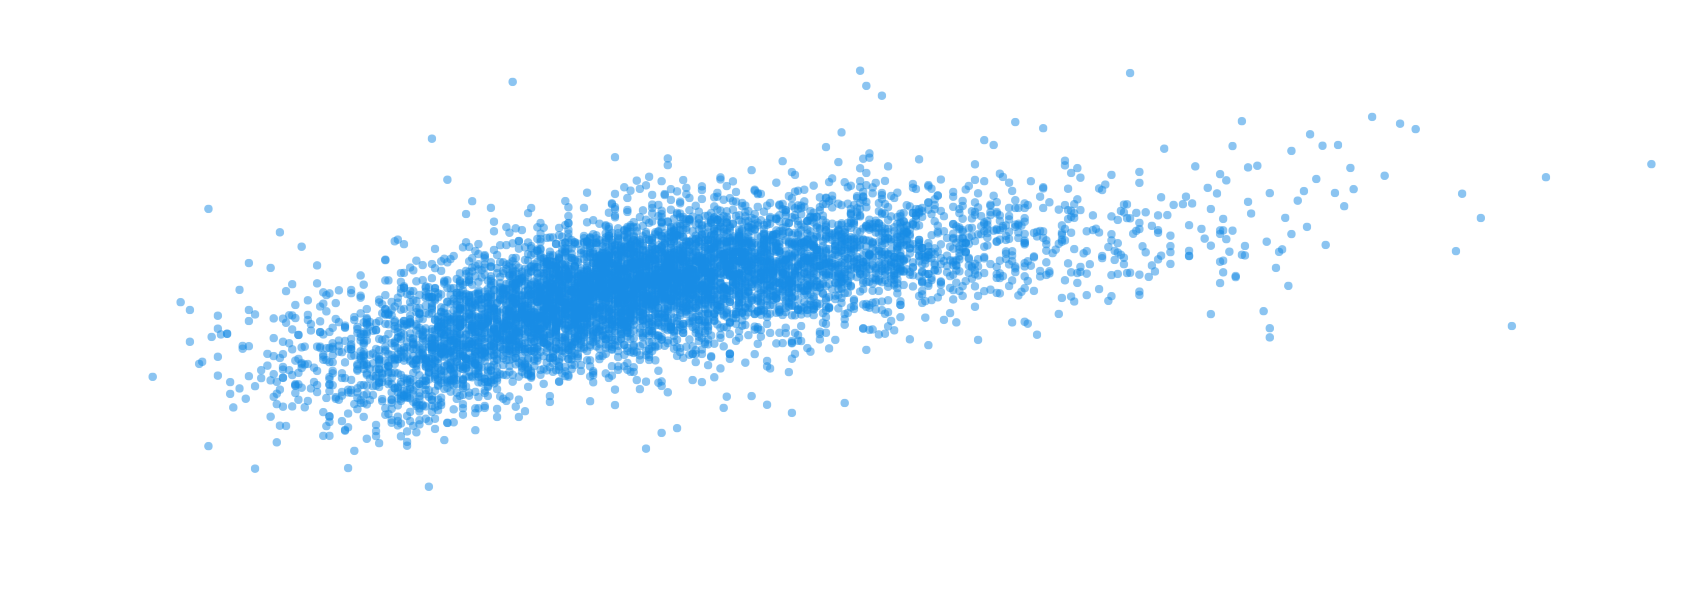
- Source: Health Foundation analysis of Office for National Statistics, Income Estimates for Small Areas, England & Wales, 2019/2020, Life expectancy at birth and age 65 by sex for Middle layer Super Output Areas (MSOAs), England: 2016 to 2020

They mention that the most accurate measurement to show the available resources would be the **Household Income after Housing Costs**. For example, those who are categorised within lower-income households would see a larger proportion of their income taken to pay for their domestic bills.  


#### Final Decision on MSOA Income Estimation data:
- The last sheet, **Household Income after Housing Costs** will be used for analysis
- The other sheets will be saved, in the scenario that the **generalisation** does not go well. This can be used for **sensitivity analysis, model stress tests** etc.

1.5 **Filter the dataset**, so that I am only focusing on values for the geographical area of London. Then do the steps mentioned above (i.e. Final Decision.....)

In [3]:
# Defining the sheet names; one for analysis and the rest for backup
chosen_sheet = "Net income after housing costs"
other_sheets = ["Total weekly income", "Net weekly income", "Net income before housing costs"]

# Defining a function to filter for only London data
def filtering_for_london(data):
    return data[data['region_name'].str.lower() == 'london']

# Separating the chosen sheet for analysis
chosen_data = adjust_data[chosen_sheet]
print(f"Processing the data for {chosen_sheet}")

# Filtering for only the London data
filtered_chosen_data = filtering_for_london(chosen_data)
print(f"Successfully filtered {chosen_sheet} for London data")

# Saving the chosen sheet after filtering for London data
chosen_file_name = f"{processed_path}msoa_income_{chosen_sheet.replace(' ', '_').lower()}.csv"
filtered_chosen_data.to_csv(chosen_file_name, index = False)
print(f"{chosen_file_name} has been saved successfully. \n")

# Separating the remaining sheets for backup
for sheet in other_sheets:
    msoa_income_data = adjust_data[sheet]
    print(f"Processing the data for {sheet}")

    # Filtering for only London data
    filtered_msoa_data = filtering_for_london(msoa_income_data)
    print(f"Successfully filtered {chosen_sheet} for London data")

    # Saving each backup sheet after filtering for London
    backup_file_name = f"{processed_path}backup_msoa_income_{sheet.replace(' ', '_').lower()}.csv"
    filtered_msoa_data.to_csv(backup_file_name, index = False)
    print(f"{backup_file_name} has been saved successfully. \n")

Processing the data for Net income after housing costs
Successfully filtered Net income after housing costs for London data
../../data/processed/msoa_income_net_income_after_housing_costs.csv has been saved successfully. 

Processing the data for Total weekly income
Successfully filtered Net income after housing costs for London data
../../data/processed/backup_msoa_income_total_weekly_income.csv has been saved successfully. 

Processing the data for Net weekly income
Successfully filtered Net income after housing costs for London data
../../data/processed/backup_msoa_income_net_weekly_income.csv has been saved successfully. 

Processing the data for Net income before housing costs
Successfully filtered Net income after housing costs for London data
../../data/processed/backup_msoa_income_net_income_before_housing_costs.csv has been saved successfully. 



The backup data and the chosen data were separated, filtered and stored successfully. Therefore, I can move on to preprocessing the LSOA Crime data. 

## The Preprocessing/EDA of LSOA crime data by the London Metropolitan Police

Data source: https://data.london.gov.uk/dataset/recorded_crime_summary

I was going to use this data for analysis, but I realised that the LSOA Census Data has the same data. I have compared the values of their respective features, and they match, but a few have small differences. I think the London Metropolitan Police source is more accurate. However, the differences are very small, and due to some of the other limitations in the analysis, it would be feasible to omit this dataset. Therefore, I'll leave this in my final notebook, just in case it is needed for further analysis. 

## The Preprocessing/EDA of LSOA crime data by the London Metropolitan Police

Data source: https://data.london.gov.uk/dataset/recorded_crime_summary

I was going to use this data for analysis, but I realised that the LSOA Census Data has the same data. I have compared the values of their respective features, and they match, but a few have small differences. I think the London Metropolitan Police source is more accurate. However, the differences are very small, and due to some of the other limitations in the analysis, it would be feasible to omit this dataset. Therefore, I'll leave this in my final notebook, just in case it is needed for further analysis. 

## Merging two datasets into one dataset before feature engineering 

1. Merge the lsoa_census data with the msoa_income_net_income_after_housing_costs.csv'

The primary key to linking both datasets is the names (lsoa) and the msoa_names. The prefixes of those columns match but some of the MSOAs and LSOAs do not match due to many boundary rearrangements at the end of 2011. Therefore, I made a separate csv.file extract the rows that do not match, and I will inspect them individually with the website https://findthatpostcode.uk/. This website gives me the active and inactive MSOAs and LSOAs. Also, some of the MSOAs will have LSOAs that have the same income values because certain MSOAs were split into two. Some MSOAs will have LSOAs who have the average values of two MSOAs that consolidated at 2011. 

In [6]:
# Loading the data
msoa_income_path = '../../data/processed/msoa_income_net_income_after_housing_costs.csv'
msoa_income_data = pd.read_csv(msoa_income_path)

# Extract the prefix from 'names' in the LSOA data
merged_data['msoa_prefix'] = merged_data['names'].str.extract(r'(^.* \d+)')

# Merge based on the prefix
merged_data_with_income = pd.merge(
    merged_data, 
    msoa_income_data, 
    left_on='msoa_prefix', 
    right_on='msoa_name', 
    how='left'
)

# Extracting unmatched rows from the MSOA income data
unmatched_msoa = msoa_income_data[~msoa_income_data['msoa_name'].isin(merged_data['msoa_prefix'].unique())]

# Saving the results
merged_data_path = '../../data/processed/lsoa_census_merged_with_income.csv'
unmatched_msoa_path = '../../data/processed/unmatched_msoa.csv'

# Saving the merged data
merged_data_with_income.to_csv(merged_data_path, index=False)

# Saving the unmatched MSOA data
unmatched_msoa.to_csv(unmatched_msoa_path, index=False)

# Displaying the outputs to check
print("Merged Data Preview:")
print(merged_data_with_income.head())

print("\nUnmatched MSOA Data Preview:")
print(unmatched_msoa.head())

Merged Data Preview:
   lsoa_code                names  all_ages_count_2011  \
0  E01000001  City of London 001A               1465.0   
1  E01000002  City of London 001B               1436.0   
2  E01000003  City of London 001C               1346.0   
3  E01000004  City of London 001D               2143.0   
4  E01000005  City of London 001E                985.0   

   ages_65_plus_count_2011  working_age_count_2011  persons_per_hectare_2011  \
0                    268.0                  1082.0                112.865948   
1                    269.0                  1024.0                 62.872154   
2                    254.0                   988.0                227.749577   
3                    117.0                  1932.0                  9.354402   
4                    127.0                   694.0                 51.951477   

   couples_with_children_percent_2011  couples_without_children_percent_2011  \
0                            7.648402                              24

After going through each unmatched row, the missing values of the merged dataset has been restored in their correct places.

In [8]:
# Reloading the updated dataset
updated_data_path = '../../data/processed/lsoa_census_merged_with_income.csv'
merged_data_with_income = pd.read_csv(updated_data_path)

print("Updated dataset loaded successfully.")

# Checking for missing values
missing_values = merged_data_with_income.isnull().sum()

# Displaying columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Updated dataset loaded successfully.
Columns with missing values:
child_tax_credit_lone_parent_percent_2011    1
child_out_of_work_benefit_percent_2012       1
dtype: int64


Using KNN Imputation for 

In [9]:
from sklearn.impute import KNNImputer

# Creating a KNN imputer instance
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors if needed

# Applying KNN Imputation (excluding non-numeric columns)
numeric_columns = merged_data_with_income.select_dtypes(include=['float64', 'int64']).columns
merged_data_with_income[numeric_columns] = imputer.fit_transform(merged_data_with_income[numeric_columns])

# Displaying completion message
print("KNN imputation completed.")


# Generating the descriptive statistics for numeric columns
summary_stats = merged_data_with_income.describe()

print("Quick Statistical Summary:")
print(summary_stats)

KNN imputation completed.
Quick Statistical Summary:
       all_ages_count_2011  ages_65_plus_count_2011  working_age_count_2011  \
count          4762.000000              4762.000000             4762.000000   
mean           1714.973436               189.850168             1184.058484   
std             325.491626                75.091826              285.467505   
min             623.250000                24.000000              387.750000   
25%            1536.000000               135.000000             1012.000000   
50%            1661.000000               178.000000             1131.500000   
75%            1826.750000               234.000000             1287.750000   
max            6289.000000               599.000000             5023.000000   

       persons_per_hectare_2011  couples_with_children_percent_2011  \
count               4762.000000                         4762.000000   
mean                  94.873933                           18.558813   
std                   

Looking at the statistical summary, I can see that the confidence intervals are consistent with the net income after housing costs. The columns have a minimum value of 0, which could be outliers. I will do more checks in the feature engineering part of my notebook (feature_poc.ipynb).

## Feature Engineering/ Selection

1. Standardisation

The numerical columns (features) will all be standardised to get ready for regression and classification models. So I am making sure that I only have numerical columns only and that any non-numerical columns (id/categoriees/object datatypes) are left the same. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [65]:
# The path to the updated dataset (the merged dataset)
updated_file_path = '../../data/processed/lsoa_census_merged_with_income.csv'

# Loading the updated dataset
merged_data_with_income = pd.read_csv(updated_file_path)

In [5]:
# Displaying a preview to confirm that the data is loaded correctly
print("Loaded Data Preview:")
print(merged_data_with_income.head())


# Identifying the numerical columns
numerical_cols = merged_data_with_income.select_dtypes(include=['float64', 'int64']).columns

# Initialising the scaler
scaler = StandardScaler()

# Standardising the numerical features
merged_data_with_income[numerical_cols] = scaler.fit_transform(merged_data_with_income[numerical_cols])

# Verifying the transformation
print("Standardized Data (First Few Rows):")
print(merged_data_with_income[numerical_cols].head())

# Saving the standardised data for the next steps
standardized_data_path = '../../data/processed/lsoa_census_standardized.csv'
merged_data_with_income.to_csv(standardized_data_path, index=False)


Loaded Data Preview:
   lsoa_code                      names  all_ages_count_2011  \
0  E01000027  Barking and Dagenham 001A               1709.0   
1  E01000028  Barking and Dagenham 001B               1549.0   
2  E01000029  Barking and Dagenham 001C               1602.0   
3  E01000030  Barking and Dagenham 001D               1915.0   
4  E01000031  Barking and Dagenham 002A               1617.0   

   ages_65_plus_count_2011  working_age_count_2011  persons_per_hectare_2011  \
0                    232.0                  1009.0                 11.590370   
1                    220.0                   913.0                107.719054   
2                    445.0                   869.0                 62.358895   
3                    204.0                  1132.0                 66.887880   
4                    231.0                  1033.0                 19.170124   

   couples_with_children_percent_2011  couples_without_children_percent_2011  \
0                           21.06

2. Feature Selection:
    - Correlation Matrix: I am trying to find the relationships between variables (features) and net income after housing costs. This will show me linearity of the relationships with net income. I also will look at for signs of multicollinearity. 

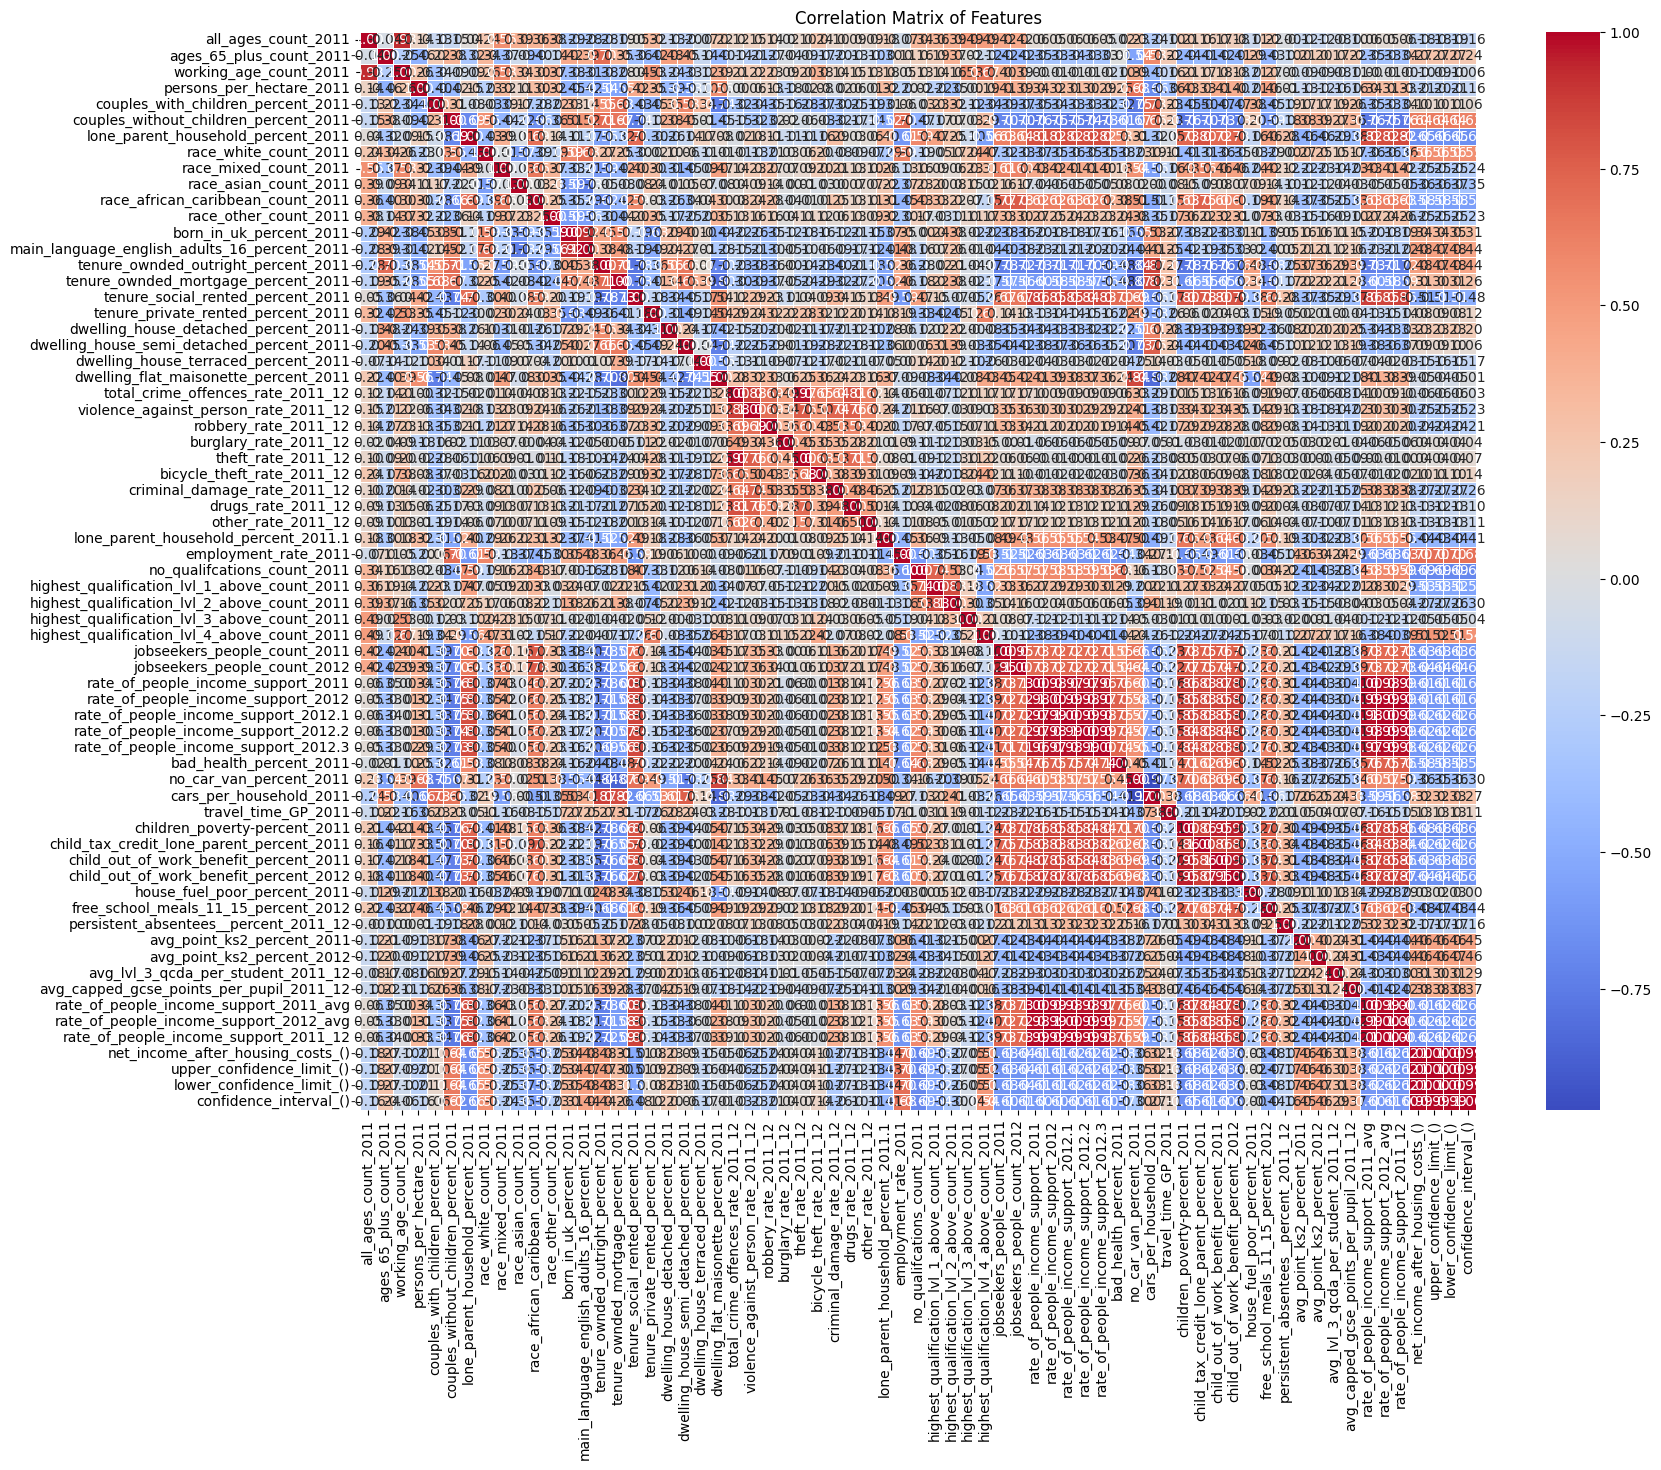

net_income_after_housing_costs_()         1.000000
upper_confidence_limit_()                 0.999435
lower_confidence_limit_()                 0.999247
confidence_interval_()                    0.989209
employment_rate_2011                      0.697535
                                            ...   
jobseekers_people_count_2012             -0.636382
child_out_of_work_benefit_percent_2012   -0.644945
lone_parent_household_percent_2011       -0.653230
children_poverty-percent_2011            -0.678347
no_qualifcations_count_2011              -0.693334
Name: net_income_after_housing_costs_(), Length: 67, dtype: float64


In [8]:

# Selecting only the numeric columns
numeric_columns = merged_data_with_income.select_dtypes(include=['number']).columns

# Computing the correlation matrix for the numeric columns
correlation_matrix = merged_data_with_income[numeric_columns].corr()

# Plotting the correlation matrix for all variables (features)
plt.figure(figsize = (18, 14))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = 0.5)
plt.title('Correlation Matrix of Features')
plt.show()

# Focusing on the features that are related to net income
income_related_features = correlation_matrix['net_income_after_housing_costs_()'].sort_values(ascending = False)
print(income_related_features)

# Saving income related correlations to a csv file
income_related_features.to_csv('../../data/raw/income_related_features.csv', header=True)

From the results of the variables which relate to net income. A quick overview would see that the confidence intervals show very high correlations which will likely cause multicollinearity. My estimation based on the analysis so far is that the best features (positive correlation) are:  employment_rate_2011, couples_without_children_percent_2011, race_white_count, highest_qualification_lvl_4_above_count_2011. And the best negative correlations with net income seems to be: no_qualification_count_2011, children_poverty-percent_2011, lone_parent_household_percent_2011, jobseekers_people_count_2011, rate_of_people_income_support_2012_avg, rate_of_people_income_support_2011_12, child_tax_credit_lone_parent_percent_2011, rate_of_people_income_support_2012, and the list goes on.


   - Using Random Forest for Feature Importance:

     Random Forest is an ensemble learning method, and I will use this to assess the importance of various predictors.

In [15]:
from sklearn.ensemble import RandomForestRegressor

# Ensuring the target variable (y) is numeric and drop rows where y has missing values
y = merged_data_with_income['net_income_after_housing_costs_()']
y = pd.to_numeric(y, errors='coerce')
y = y.dropna()

# Selecting only numeric columns for the feature set (X), then dropping rows where X has missing values
numeric_columns = merged_data_with_income.select_dtypes(include = ['number']).columns
X = merged_data_with_income[numeric_columns].drop(columns = ['net_income_after_housing_costs_()'])

# Aligning X and y by dropping rows where any value in X or y is NaN
X = X.loc[y.index]

# Fitting the model
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_model.fit(X, y)

# Getting the feature importance
feature_importances = pd.DataFrame(rf_model.feature_importances_, 
                                   index = X.columns, 
                                   columns = ["Importance"]).sort_values("Importance", ascending = False)

# Displaying the feature importances
print(feature_importances)
feature_importances.to_csv('../../data/raw/importance_features.csv', header = True)

                                        Importance
lower_confidence_limit_()                 0.697474
upper_confidence_limit_()                 0.301429
confidence_interval_()                    0.000309
born_in_uk_percent_2011                   0.000033
race_asian_count_2011                     0.000032
...                                            ...
rate_of_people_income_support_2011_12     0.000004
rate_of_people_income_support_2011        0.000004
rate_of_people_income_support_2012.1      0.000004
rate_of_people_income_support_2012_avg    0.000004
rate_of_people_income_support_2012        0.000003

[66 rows x 1 columns]


- Threshold for feature importance.
There are many features that show very low importance values, therefore, I will set a threshold of 1e-5 to try and simplify the model. I may have to tune the hyperparameters such as max_depthm min_samples_leaf.

In [16]:
# Setting a threshold for feature importance
threshold = 1e-5
important_features = feature_importances[feature_importances['Importance'] > threshold].index

# Filtering the dataset to include only important features
X_important = X[important_features]

# Re-train the model with only the selected features
rf_model.fit(X_important, y)

# Displaying the updated feature importances
print(rf_model.feature_importances_)

[6.97245782e-01 3.01606234e-01 3.68833217e-04 4.08744079e-05
 4.00342019e-05 3.14775611e-05 3.20749612e-05 2.57652157e-05
 2.41927343e-05 2.45609218e-05 2.12252011e-05 2.31141399e-05
 2.23087599e-05 2.23551233e-05 1.89896436e-05 2.08637614e-05
 2.08408329e-05 2.04008411e-05 1.77504369e-05 2.00239389e-05
 1.86656399e-05 1.71573863e-05 1.97793782e-05 1.93961361e-05
 1.67090486e-05 1.52610572e-05 1.46569872e-05 1.55201064e-05
 1.43264103e-05 1.62918033e-05 1.55689509e-05 1.52164484e-05
 1.49063515e-05 1.60732853e-05 1.69228173e-05 1.56845419e-05
 1.80639327e-05 1.55005376e-05 1.32208105e-05 1.60100782e-05
 1.37949390e-05 1.35721506e-05]


Retrain it again to see if there are stronger values.

In [17]:
# Defining the threshold for feature importance 
threshold = 1e-5

# Selecting features with an importance greater than the threshold
important_features = [feature for feature, importance in zip(X.columns, rf_model.feature_importances_) if importance > threshold]

# Filtering the dataset to include only important features
X_important = X[important_features]

# Retraining the model with the selected features
rf_model.fit(X_important, y)

# Evaluating the model's performance again after feature selection
y_pred = rf_model.predict(X_important)
print("Model R^2:", rf_model.score(X_important, y))

Model R^2: 0.9699265907809371


That is a very high score for R^2, which shows that the model explain most of the variance. However, it may be overfitting, so I want to check through cross validation and then tune the hyperparameters. 

- Cross_Validation:

  Performing cross-validation with 5 folds to check for overfitting. 

In [18]:
from sklearn.model_selection import cross_val_score

# Performing cross-validation to check for overfitting
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')  # 5-fold cross-validation
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean R² score from cross-validation: {cv_scores.mean()}")


Cross-validation R² scores: [0.99852045 0.99833546 0.99842588 0.99874294 0.99662056]
Mean R² score from cross-validation: 0.9981290588773529


The results above suggest that the model is generalising well. Then results are between 0.996 and 0.998.

I'm going to use the GridSearchCV function to tune the hyperparamaters to see if I can make improvements.

In [19]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv = 5,  # 5-fold cross-validation
                           scoring = 'r2',  # Evaluating by R² score
                           n_jobs = -1,  # Using all CPU cores
                           verbose = 2)

# Fitting the grid search
grid_search.fit(X, y)

# Getting the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation R² score: {best_score}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation R² score: 0.9981476819056905


The results of the GridSearchCV was the following: The best parameters were: a max_depth of 10 levels, min_samples_leaf of 2, min_samples_split of 10 and a n_estimators count of 300. The best cross-validation R squared score of 0.9981 is an improvement compared to the value before this process. 

Personally, I think I have too many features. The RF model was performing very well and it was not overfitting and was actually generalising well. 

- Reduce the Numbers of Features:

  Increase the threshold of feature importance to 0.001.

In [28]:
threshold = 0.001  # Increase the threshold to keep only the most important features
important_features = [feature for feature, importance in zip(X.columns, rf_model.feature_importances_) if importance > threshold]

# Filter the dataset to include only important features
X_important = X[important_features]

# Re-train the model with the selected features
rf_model.fit(X_important, y)

# Evaluate the model's performance again after feature selection
y_pred = rf_model.predict(X_important)
print("Model R^2:", rf_model.score(X_important, y))

Model R^2: 0.9699265907809371


After the less important features had been filtered out, the R squared value was still high at roughly 0,97. 

- Removal/Identification of High Correlated Features

  There were variables that correlated close to 1, such as the confidence intervals of the target variable. To reduce multicollinearity, they should be removed.

In [29]:
# Compute the correlation matrix
corr_matrix = X.corr()

# Identify highly correlated features (correlation > 0.9)
corr_threshold = 0.9
highly_corr_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            highly_corr_features.add(colname)

# Drop the highly correlated features
X_reduced = X.drop(columns=highly_corr_features)

# Re-train the model with the reduced feature set
rf_model.fit(X_reduced, y)

# Evaluate the model's performance
y_pred = rf_model.predict(X_reduced)
print("Model R^2:", rf_model.score(X_reduced, y))

Model R^2: 0.9998903975919191


After the model was retrained without the highly correlated features, the R squared value showed a major improvement by increasing to 0.999. To be honest, these results starting from the adjustment of the first feature importance threshold, seem suspiciously high though I tested for overfitting. It is hard to believe that it is performing so well. Though this is the training R squared value, it still suspect that this model is overfitting. Let me check the cross validation R squared.

- Cross-Validation after Reducing Highly Correlated Features

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Perform cross-validation with the existing RandomForestRegressor model
cv_scores = cross_val_score(rf_model, X_important, y, cv=5, scoring='r2')  # 5-fold cross-validation

# Output cross-validation results
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean R² score from cross-validation: {cv_scores.mean()}")

Cross-validation R² scores: [0.74881451 0.69703875 0.75690217 0.78653271 0.72755194]
Mean R² score from cross-validation: 0.7433680172070624


The R squared values have reduced significantly, ranging from 0.697 to 0.748. And with a mean R squared score of 0.743. This indicates that the model may not generalise as successful with the removal of the highly correlated features. I think there is overfitting involved because the their is a sizeable drop from the training R squared value and the cross-validation R squared value.

Maybe I should start again with the feature engineering and selection, but removing the features with lower importance and also removing or combining the features that have very high correlations (i.e. confidence intervals). 

## Feature Engineering/Selection (PART 2) **ITERATION""

I see that I have made some mistakes. However, I am glad that I did some practice on feature importance, cross-validation and hyperparameter tuning.

- Previous Findings:
  1. The RF model achieved a high training R squared value compared with the lower cross-validation R squared value after removing the highly correlated features. This was suspicious.
  2. After investigating my previous steps, I see that I had forgotten to aggregate LSOA-level features (demographics/crime data) to MSOA level features. The target variable, which is the MSOA estimated mean income, does not match with the granular LSOA-level predictors. This means there are multiple rows of LSOA codes will have the same MSOA mean income value. 
  3. The RF model may have captured the effects that resulted from the misalignment of the scales (LSOA level vs MSOA level), subsequently causing the suspiciously high R squared value. 

- **KNN Regression**
- KNN Regression was chosen because it matches well with my research questions. The first question is about predicting LSOA income from MSOA data, where local patterns and trends can be captured for income distribution. The second question is about predicting LSOA incomes with MSOA estimates,and KNN models can find the closest MSOAs to estimate LSOA-level income. The third questions is about finding good predictors of income, and KNN models can take a large number of variables in different ways, such as using PCA or removing multiple redundant features.
   1. Begin with handling the outliers using z-score and IQR because I didn't do this previously. 


Summary Statistics Before Outlier Handling
       all_ages_count_2011  ages_65_plus_count_2011  working_age_count_2011  \
count          4762.000000              4762.000000             4762.000000   
mean           1714.973436               189.850168             1184.058484   
std             325.491626                75.091826              285.467505   
min             623.250000                24.000000              387.750000   
25%            1536.000000               135.000000             1012.000000   
50%            1661.000000               178.000000             1131.500000   
75%            1826.750000               234.000000             1287.750000   
max            6289.000000               599.000000             5023.000000   

       persons_per_hectare_2011  couples_with_children_percent_2011  \
count               4762.000000                         4762.000000   
mean                  94.873933                           18.558813   
std                   59.475236

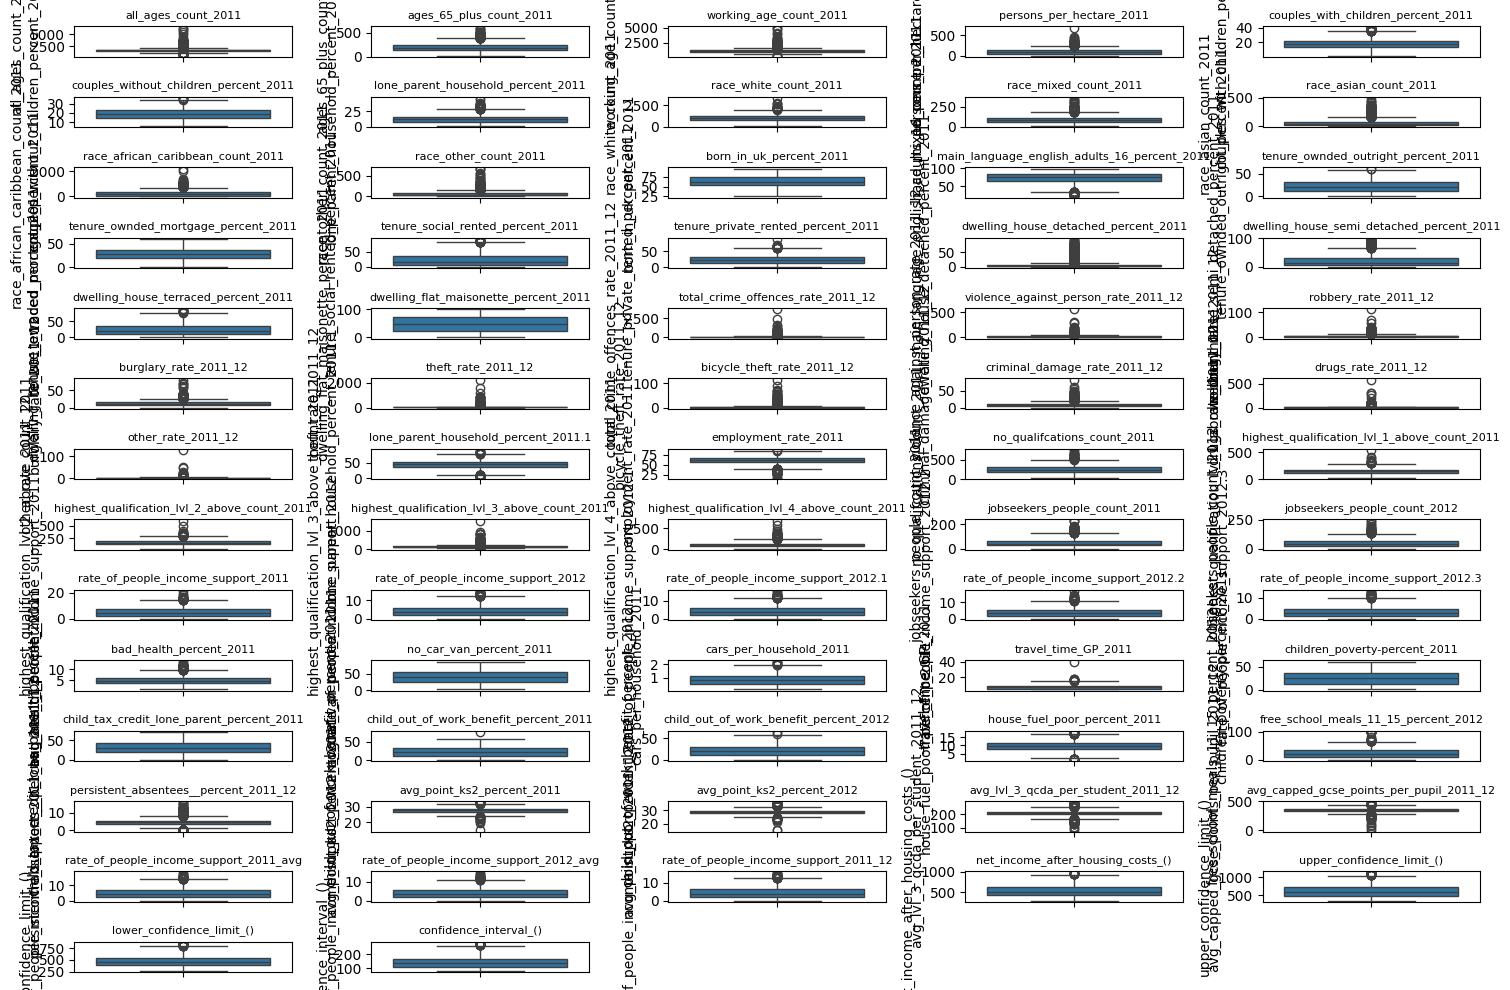

In [8]:
# Identifying the numerical columns
numerical_cols = merged_data_with_income.select_dtypes(include=['float64', 'int64']).columns

# Creating a function to display the summary 
def display_summary_statistics(data, title):
    print(f"\n{title}")
    print(data.describe())

# Creating a function to plot boxplots
def plot_boxplots(data, numerical_cols, title):
    print(f"\nMaking boxplots: {title}")
    plt.figure(figsize = (15, 10))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols) // 5 + 1, 5, i)
        sns.boxplot(y = data[col])
        plt.title(col, fontsize = 8)
        plt.tight_layout()
    plt.show()

# Displaying summary statistics before outlier handling
display_summary_statistics(merged_data_with_income, "Summary Statistics Before Outlier Handling")
plot_boxplots(merged_data_with_income, numerical_cols, "Before Outlier Handling")

# Outlier handling using Z-scores
z_scores = merged_data_with_income[numerical_cols].apply(zscore)
outliers_z = (z_scores.abs() > 3)

# Outlier handling using IQR
Q1 = merged_data_with_income[numerical_cols].quantile(0.25)
Q3 = merged_data_with_income[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (merged_data_with_income[numerical_cols] < (Q1 - 1.5 * IQR)) | (merged_data_with_income[numerical_cols] > (Q3 + 1.5 * IQR))

# Combining outlier masks
combined_outliers = outliers_z | outliers_iqr

# Replacing outliers using KNN Imputation
imputer = KNNImputer(n_neighbors = 5)
merged_data_with_income[numerical_cols] = imputer.fit_transform(merged_data_with_income[numerical_cols].where(~combined_outliers, other=pd.NA))

# Standardising the numerical features
scaler = StandardScaler()
merged_data_with_income[numerical_cols] = scaler.fit_transform(merged_data_with_income[numerical_cols])


Making boxplots: Before Outlier Handling


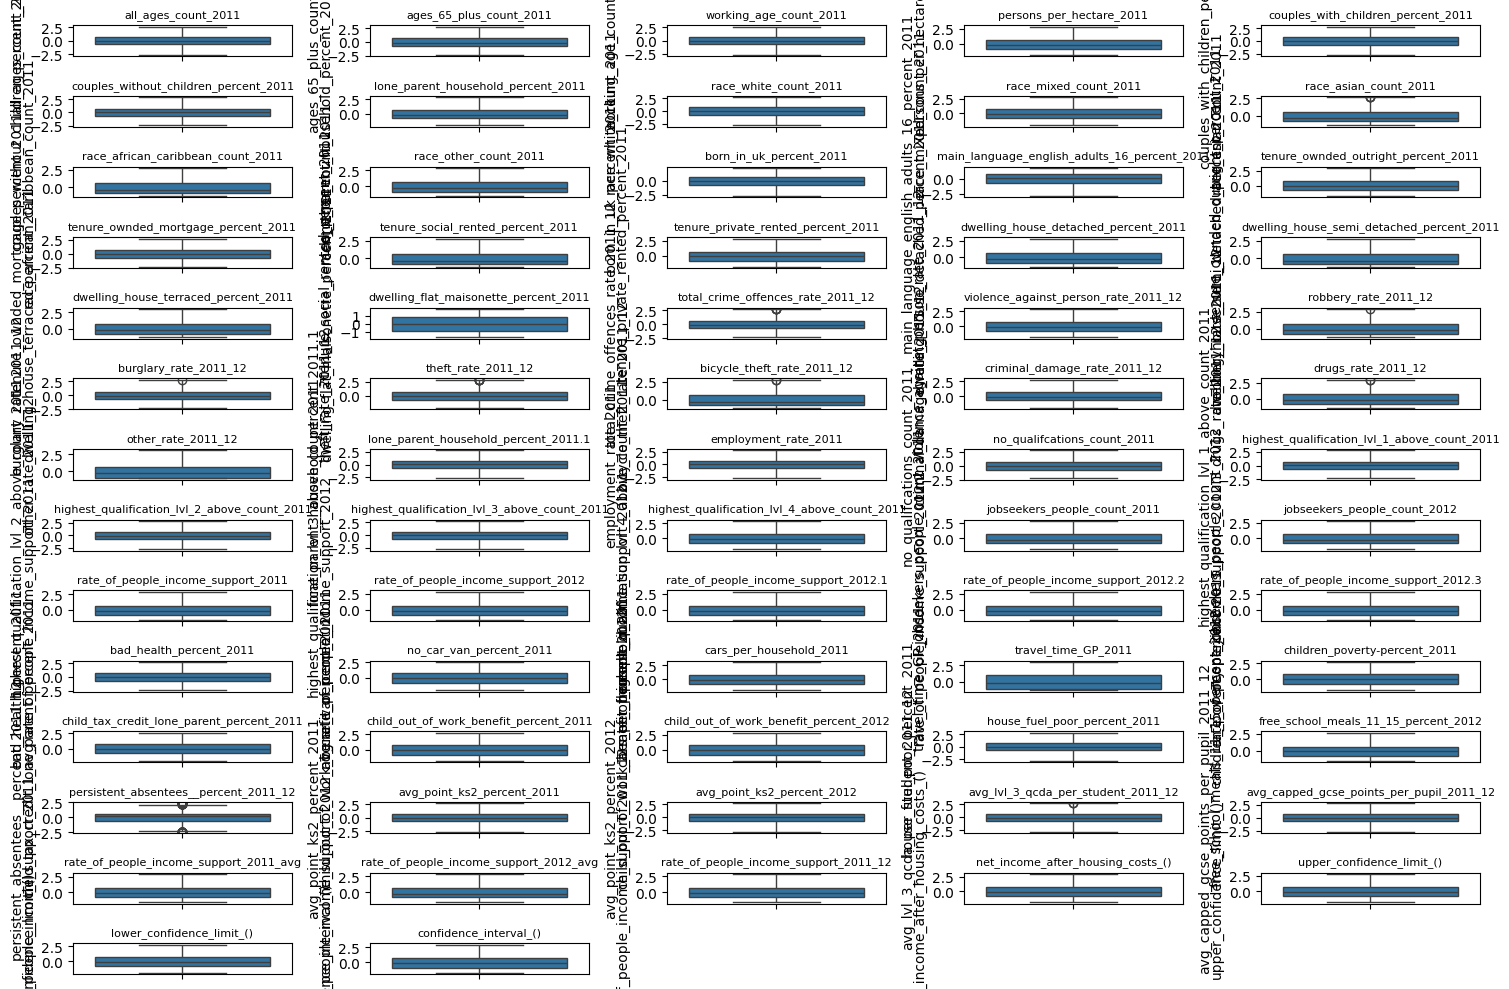

In [12]:
# Displaying summary boxplots before outlier handling
plot_boxplots(merged_data_with_income, numerical_cols, "Before Outlier Handling")

# Outlier handling using Z-scores
z_scores = merged_data_with_income[numerical_cols].apply(zscore)
outliers_z = (z_scores.abs() > 3)

# Outlier handling using IQR
Q1 = merged_data_with_income[numerical_cols].quantile(0.25)
Q3 = merged_data_with_income[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (merged_data_with_income[numerical_cols] < (Q1 - 1.5 * IQR)) | (merged_data_with_income[numerical_cols] > (Q3 + 1.5 * IQR))

# Combining outlier masks
combined_outliers = outliers_z | outliers_iqr

# Replacing outliers using KNN Imputation
imputer = KNNImputer(n_neighbors = 5)
merged_data_with_income[numerical_cols] = imputer.fit_transform(merged_data_with_income[numerical_cols].where(~combined_outliers, other=pd.NA))

# Standardising the numerical features
scaler = StandardScaler()
merged_data_with_income[numerical_cols] = scaler.fit_transform(merged_data_with_income[numerical_cols])

In [9]:
# Verifying the transformation
print("Standardised Data (First Few Rows):")
print(merged_data_with_income[numerical_cols].head())

# Saving the standardised data for the next steps
standardized_data_path = '../../data/processed/lsoa_census_standardized.csv'
merged_data_with_income.to_csv(standardized_data_path, index = False)

Standardised Data (First Few Rows):
   all_ages_count_2011  ages_65_plus_count_2011  working_age_count_2011  \
0             0.097562                 0.642471               -0.750440   
1            -0.627412                 0.469262               -1.221893   
2            -0.387265                 0.564527               -1.437975   
3             1.030966                 0.238318               -0.146392   
4            -0.319298                 0.628037               -0.632577   

   persons_per_hectare_2011  couples_with_children_percent_2011  \
0                 -1.537146                            0.435552   
1                  0.316938                           -0.360592   
2                 -0.557947                           -0.403244   
3                 -0.470594                            0.059540   
4                 -1.390952                            0.606339   

   couples_without_children_percent_2011  lone_parent_household_percent_2011  \
0                             

PermissionError: [Errno 13] Permission denied: '../../data/processed/lsoa_census_standardized.csv'

In [14]:
# Displaying summary statistics and boxplots after outlier handling
display_summary_statistics(merged_data_with_income, "Summary Statistics After Outlier Handling")


Summary Statistics After Outlier Handling
       all_ages_count_2011  ages_65_plus_count_2011  working_age_count_2011  \
count         4.762000e+03              4762.000000             4762.000000   
mean          5.968440e-18                 0.000000                0.000000   
std           1.000105e+00                 1.000105                1.000105   
min          -2.653967e+00                -2.361512               -2.721960   
25%          -6.882329e-01                -0.757922               -0.735959   
50%          -1.194442e-01                -0.136711               -0.150973   
75%           6.222563e-01                 0.657860                0.610983   
max           2.583440e+00                 2.752640                2.631395   

       persons_per_hectare_2011  couples_with_children_percent_2011  \
count              4.762000e+03                        4.762000e+03   
mean               1.193688e-17                        2.387376e-17   
std                1.000105e+00 


Making boxplots: After Outlier Handling


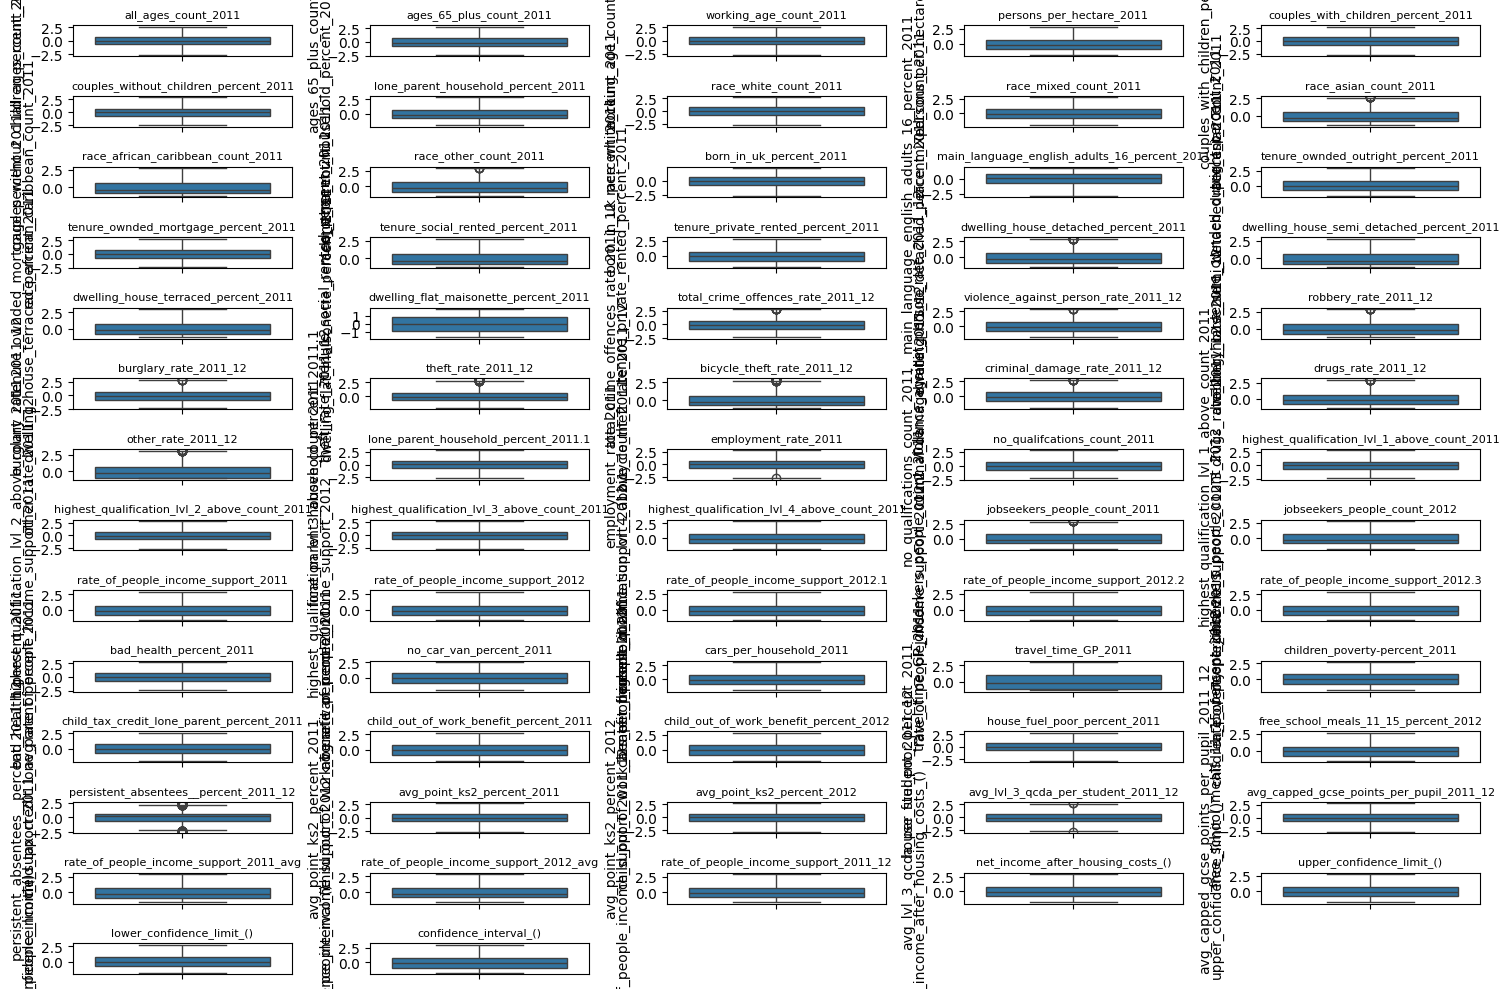

In [10]:
# Displaying summary boxplots after outlier handling
plot_boxplots(merged_data_with_income, numerical_cols, "After Outlier Handling")

## Feature Engineering/ Selection (PART 3) ** ITERATION**

The last evaluation from KNN Regression, showed an MAE of 0.249 which is good result as this should be in the same units as the estimated income. RMSE is 0.331 which shows that the KNN model is fitting good but it can perform better. R squared is 0.892, which is high. You will see the scatter plot for this model further down in the model evaluation section. I wanted to come back to 

In [66]:
# Selecting only numeric columns (without the target variable)
X = merged_data_with_income.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
X = X.drop(columns=['net_income_after_housing_costs_()'])  # Dropping the target column from the dataset

# Defining the target variable
y = merged_data_with_income['net_income_after_housing_costs_()']  # Target variable

# Split the data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Train a RandomForest model to get feature importances
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display the results
importance_data = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features by importance
importance_data = importance_data.sort_values(by = 'Importance', ascending = False)

# Show all the rows in the Pandas DataFrame
pd.set_option('display.max_rows', None)

# Display the sorted feature importance
print(importance_data)

                                         Feature  Importance
64                     lower_confidence_limit_()    0.646152
63                     upper_confidence_limit_()    0.352761
65                        confidence_interval_()    0.000249
9                          race_asian_count_2011    0.000034
12                       born_in_uk_percent_2011    0.000027
3                       persons_per_hectare_2011    0.000024
11                         race_other_count_2011    0.000023
20          dwelling_house_terraced_percent_2011    0.000021
0                            all_ages_count_2011    0.000021
32                          employment_rate_2011    0.000020
25                         burglary_rate_2011_12    0.000020
53                  house_fuel_poor_percent_2011    0.000020
37  highest_qualification_lvl_4_above_count_2011    0.000019
7                          race_white_count_2011    0.000019
18          dwelling_house_detached_percent_2011    0.000019
31          lone_parent_

- **Feature Importance After Removing the Confidence Intervals**
  - This is a tricky situation. I do not know if the confidence intervals will enhance or be relevant to predicting LSOA income estimates. They correlate highly with the target variable, but the research is primarily about using demographic, socioeconomic, crime and housing data for predictions of net income. I want to try both.

In [67]:
# Selecting only numeric columns (without the target variable)
X = merged_data_with_income.select_dtypes(include=['float64', 'int64'])  # Selecting only numeric columns
X = X.drop(columns=['net_income_after_housing_costs_()', 'lower_confidence_limit_()', 'upper_confidence_limit_()', 
                    'confidence_interval_()'])  # Dropping the confidence intervals and target column from the dataset

# Defining the target variable
y = merged_data_with_income['net_income_after_housing_costs_()']  # Target variable

# Combine the remaining predictors with the target variable
knn_no_confidence_interval = X.copy()
knn_no_confidence_interval['net_income_after_housing_costs_()'] = y

# Save the dataset to a CSV file
knn_no_confidence_interval.to_csv('../../data/processed/knn_confidence_interval.csv', index=False)

# Display a message to confirm saving
print("Dataset saved to 'merged_data_for_knn.csv'.")

# Splitting the data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Training a RandomForest model to get feature importances
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)

# Getting feature importances
feature_importances = rf.feature_importances_

# Creating a DataFrame to display the results
importance_data = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting the features by importance
importance_data = importance_data.sort_values(by = 'Importance', ascending = False)

# Showing all the rows in the Pandas DataFrame
pd.set_option('display.max_rows', None)

# Display the sorted feature importance
print(importance_data)

Dataset saved to 'merged_data_for_knn.csv'.
                                         Feature  Importance
33                   no_qualifcations_count_2011    0.272099
32                          employment_rate_2011    0.266090
49                 children_poverty-percent_2011    0.075578
10             race_african_caribbean_count_2011    0.028858
13  main_language_english_adults_16_percent_2011    0.027732
38                  jobseekers_people_count_2011    0.023392
37  highest_qualification_lvl_4_above_count_2011    0.020249
7                          race_white_count_2011    0.017739
6             lone_parent_household_percent_2011    0.016950
34  highest_qualification_lvl_1_above_count_2011    0.015984
1                        ages_65_plus_count_2011    0.015807
39                  jobseekers_people_count_2012    0.014181
50     child_tax_credit_lone_parent_percent_2011    0.009425
52        child_out_of_work_benefit_percent_2012    0.007064
5          couples_without_children_perce

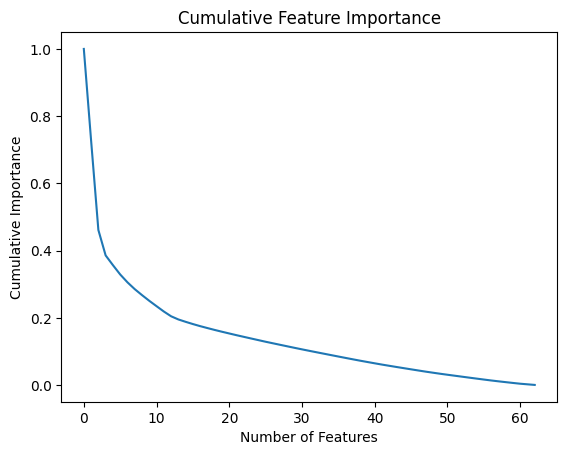

In [68]:
cumulative_importance = np.cumsum(np.sort(rf.feature_importances_))[::-1]
plt.plot(cumulative_importance)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.show()

The Cumulative Feature Importance Line Graph shows that only 2 or maybe 3 features are showing high feature importance, meaning that they should be good predictors.

- Feature Importance after removing 40+ variables that were low in feature importance.

  I did this because I want to test the models in various forms. I want to evaluate the results with the following input configurations:
  1. Only remove the confidence intervals that are directly linked to the MSOA income estimates.
  2. Remove 40+ variables and combine as much as necessary if they are the same but for a different year. Remove single variables for 2012 for consistency, and target/confidence interval variables.
  3. Use PCA to combine many variables that fall under the same categories, and remove the target variable and confidence intervals.

- **Then I will compare this with the model, where only the target variable was excluded.**

**The feature importance below is after removing 40+ variables and combining some to reduce the quantities as much as possible**

In [69]:
# Selecting only numeric columns (without the target variable)
X = merged_data_with_income.select_dtypes(include=['float64', 'int64'])  # Selecting only numeric columns

# Combine jobseekers people count for 2011 and 2012
#X['jobseekers_people_count_2011_12'] = X['jobseekers_people_count_2011'] + X['jobseekers_people_count_2012']

# Combine child out-of-work benefit percent for 2011 and 2012 
#X['child_out_of_work_benefit_percent_2011_12'] = (X['child_out_of_work_benefit_percent_2011'] + 
                                                                        #X['child_out_of_work_benefit_percent_2012']) / 2

# Combine avg_point_ks2_percent_2011 and avg_point_ks2_percent_2012 by averaging them
X['avg_point_ks2_percent_2011_12'] = (X['avg_point_ks2_percent_2011'] + X['avg_point_ks2_percent_2012']) / 2


# Selecting only numeric columns (without the target variable)
X = merged_data_with_income.select_dtypes(include=['float64', 'int64'])  # Selecting only numeric columns
X = X.drop(columns=['net_income_after_housing_costs_()', 'lower_confidence_limit_()', 'upper_confidence_limit_()', 
                    'confidence_interval_()', 'rate_of_people_income_support_2011', 'rate_of_people_income_support_2011_avg',
                   'rate_of_people_income_support_2012_avg', 'rate_of_people_income_support_2012.2',
                   'rate_of_people_income_support_2012.1', 'other_rate_2011_12', 'rate_of_people_income_support_2012.3',
                   'rate_of_people_income_support_2012', 'jobseekers_people_count_2012', 'jobseekers_people_count_2011',
                   'child_out_of_work_benefit_percent_2011', 'child_out_of_work_benefit_percent_2012',
                   'avg_point_ks2_percent_2011', 'avg_point_ks2_percent_2012', 'total_crime_offences_rate_2011_12',
                   'no_car_van_percent_2011', 'cars_per_household_2011', 'criminal_damage_rate_2011_12',
                   'dwelling_flat_maisonette_percent_2011', 'working_age_count_2011', 'all_ages_count_2011',
                   'tenure_private_rented_percent_2011', 'tenure_ownded_mortgage_percent_2011', 'travel_time_GP_2011',
                   'couples_with_children_percent_2011', 'lone_parent_household_percent_2011.1', 'avg_lvl_3_qcda_per_student_2011_12',
                   'theft_rate_2011_12', 'race_mixed_count_2011', 'race_other_count_2011', 'free_school_meals_11_15_percent_2012',
                   'persistent_absentees__percent_2011_12', 'burglary_rate_2011_12', 'dwelling_house_terraced_percent_2011',
                   'dwelling_house_detached_percent_2011', 'dwelling_house_semi_detached_percent_2011',
                   'highest_qualification_lvl_2_above_count_2011', 'tenure_social_rented_percent_2011', 'persons_per_hectare_2011',
                   'violence_against_person_rate_2011_12'])  # Dropping many supposedly redundant columns (low feature importance)

                    
# Defining the target variable
y = merged_data_with_income['net_income_after_housing_costs_()']  # Target variable

# Combine the remaining predictors with the target variable
knn_many_removed = X.copy()
knn_many_removed['net_income_after_housing_costs_()'] = y

# Save the dataset to a CSV file
knn_many_removed.to_csv('../../data/processed/knn_many_removed.csv', index = False)

# Display a message to confirm saving
print("Dataset saved to '../../data/processed/knn_many_removed.csv'.")

# Splitting the data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Training a RandomForest model to get feature importances
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)

# Getting feature importances
feature_importances = rf.feature_importances_

# Creating a DataFrame to display the results
importance_data = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting the features by importance
importance_data = importance_data.sort_values(by = 'Importance', ascending = False)

# Showing all the rows in the Pandas DataFrame
pd.set_option('display.max_rows', None)

# Display the sorted feature importance
print(importance_data)

Dataset saved to '../../data/processed/knn_many_removed.csv'.
                                         Feature  Importance
13                   no_qualifcations_count_2011    0.283212
12                          employment_rate_2011    0.273117
18                 children_poverty-percent_2011    0.095726
5              race_african_caribbean_count_2011    0.043989
7   main_language_english_adults_16_percent_2011    0.034972
0                        ages_65_plus_count_2011    0.026191
16  highest_qualification_lvl_4_above_count_2011    0.025180
2             lone_parent_household_percent_2011    0.025168
14  highest_qualification_lvl_1_above_count_2011    0.024586
3                          race_white_count_2011    0.022838
19     child_tax_credit_lone_parent_percent_2011    0.015967
1          couples_without_children_percent_2011    0.012357
15  highest_qualification_lvl_3_above_count_2011    0.011829
22         rate_of_people_income_support_2011_12    0.011436
20                  hou

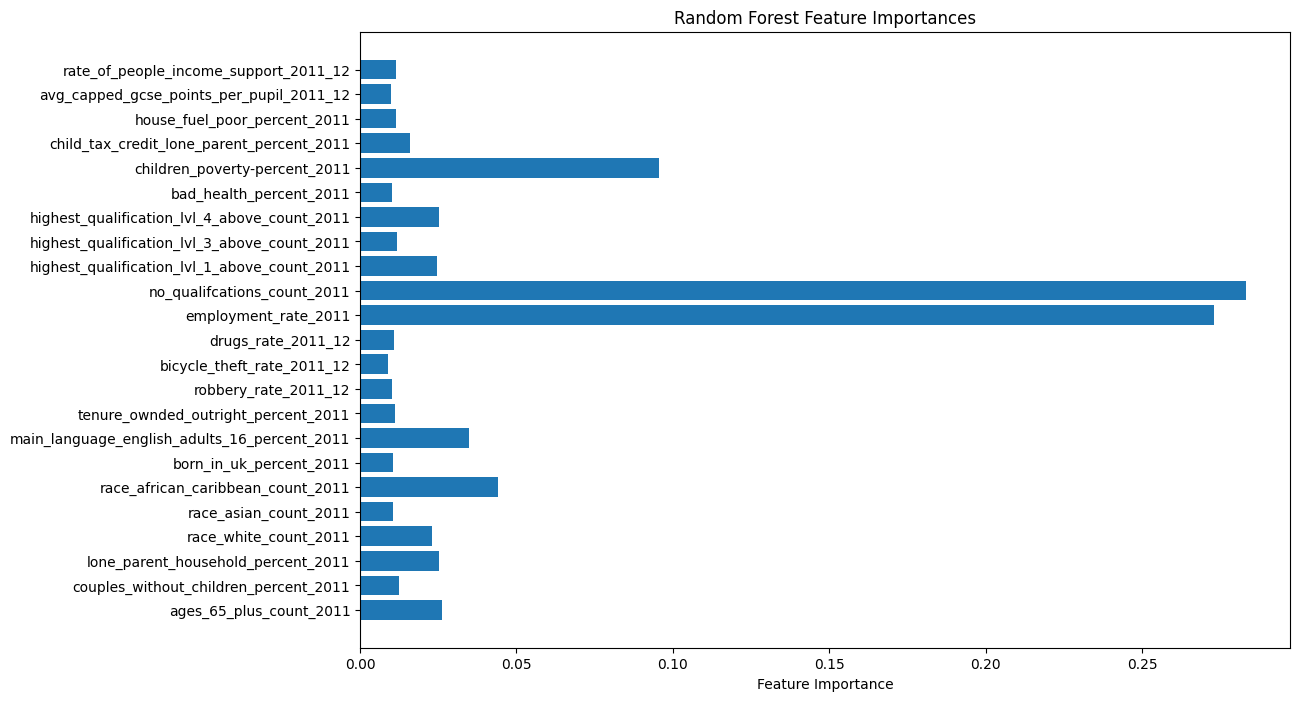

In [70]:
# Visualising Feature Importance with
# A Horizontal Bar Chart
plt.figure(figsize = (12, 8))
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

Above you will see that the two main predictors are employment_rate_2011 and no_qualifications_count_2011.

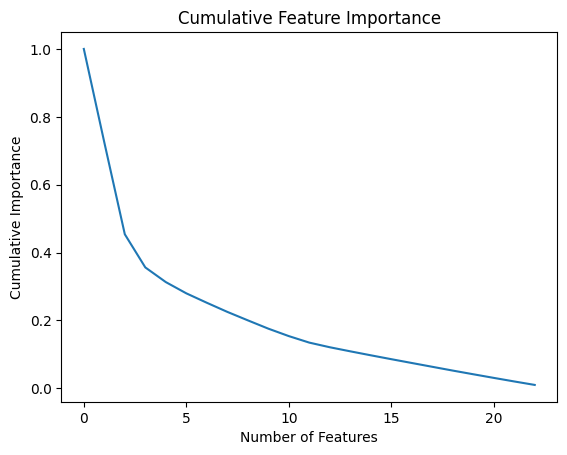

In [54]:
cumulative_importance = np.cumsum(np.sort(rf.feature_importances_))[::-1]
plt.plot(cumulative_importance)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.show()

**This is the feature importance after some PCA analysis**

In [40]:
print(merged_data_with_income.columns.tolist())

['lsoa_code', 'names', 'persons_per_hectare_2011', 'couples_with_children_percent_2011', 'couples_without_children_percent_2011', 'lone_parent_household_percent_2011', 'born_in_uk_percent_2011', 'main_language_english_adults_16_percent_2011', 'tenure_ownded_outright_percent_2011', 'total_crime_offences_rate_2011_12', 'violence_against_person_rate_2011_12', 'robbery_rate_2011_12', 'burglary_rate_2011_12', 'theft_rate_2011_12', 'bicycle_theft_rate_2011_12', 'criminal_damage_rate_2011_12', 'drugs_rate_2011_12', 'other_rate_2011_12', 'lone_parent_household_percent_2011.1', 'employment_rate_2011', 'no_qualifcations_count_2011', 'bad_health_percent_2011', 'no_car_van_percent_2011', 'cars_per_household_2011', 'travel_time_GP_2011', 'children_poverty-percent_2011', 'house_fuel_poor_percent_2011', 'persistent_absentees__percent_2011_12', 'avg_point_ks2_percent_2011', 'avg_point_ks2_percent_2012', 'avg_capped_gcse_points_per_pupil_2011_12', 'msoa_prefix', 'msoa_code', 'msoa_name', 'local_authori

In [41]:
# All the groups to combine variables in the same category.
#income_support_columns = [
    #'rate_of_people_income_support_2012.1', 
    #'rate_of_people_income_support_2012.2', 
    #'rate_of_people_income_support_2012_avg', 
    #'rate_of_people_income_support_2011_avg', 
    #'rate_of_people_income_support_2011_12', 
    #'rate_of_people_income_support_2012', 
    #'rate_of_people_income_support_2012.3', 
    #'rate_of_people_income_support_2011'
#] #COMPLETED ALREADY


#housing_columns = [
    #'dwelling_house_detached_percent_2011', 
    #'dwelling_house_semi_detached_percent_2011', 
    #'dwelling_house_terraced_percent_2011', 
    #'dwelling_flat_maisonette_percent_2011', 
    #'tenure_private_rented_percent_2011', 
    #'tenure_ownded_mortgage_percent_2011', 
    #'tenure_social_rented_percent_2011'
#] #COMPLETED ALREADY


crime_columns = [
    'bicycle_theft_rate_2011_12', 
    'robbery_rate_2011_12', 
    'criminal_damage_rate_2011_12',
    'burglary_rate_2011_12',
    'drugs_rate_2011_12',
    'violence_against_person_rate_2011_12',
    'theft_rate_2011_12',
    'other_rate_2011_12',
] # COMPLETED ALREADY

#race_columns = [
    #'race_african_caribbean_count_2011',
    #'race_white_count_2011',
    #'race_asian_count_2011',
    #'race_other_count_2011',
    #'race_mixed_count_2011'
#] # COMPLETED ALREADY

#age_columns = [
    #'ages_65_plus_count_2011',
    #'working_age_count_2011',
    #'all_ages_count_2011'

#] # COMPLETED ALREADY


#benefits_columns = [
    #'jobseekers_people_count_2011',
    #'child_tax_credit_lone_parent_percent_2011',
    #'jobseekers_people_count_2012',
    #'child_out_of_work_benefit_percent_2012',
    #'free_school_meals_11_15_percent_2012',
    #'child_out_of_work_benefit_percent_2011'
#]

#education_columns = [
    #'highest_qualification_lvl_4_above_count_2011',
    #'highest_qualification_lvl_1_above_count_2011',
    #'highest_qualification_lvl_3_above_count_2011',
    #'highest_qualification_lvl_2_above_count_2011',
    #'avg_lvl_3_qcda_per_student_2011_12'
#]


# Function to apply PCA to any given group of columns
def apply_pca_and_add_to_df(data, columns, new_column_name):
    # Standardizing the features
    scaler = StandardScaler()
    X_pca = scaler.fit_transform(data[columns])
    
    # Applying PCA (1 component)
    pca = PCA(n_components=1)
    data[new_column_name] = pca.fit_transform(X_pca)
    
    # Dropping the original columns if you no longer need them
    data.drop(columns = columns, inplace=True)

# Apply PCA to each group of features and create new columns
#apply_pca_and_add_to_df(merged_data_with_income, income_support_columns, 'rate_of_people_income_support_2011_12')
#apply_pca_and_add_to_df(merged_data_with_income, housing_columns, 'housing_and_tenure_percentages_2011')
#apply_pca_and_add_to_df(merged_data_with_income, race_columns, 'combined_race_variables_2011')
#apply_pca_and_add_to_df(merged_data_with_income, age_columns, 'combined_age_variables_2011')
apply_pca_and_add_to_df(merged_data_with_income, crime_columns, 'combined_crime_rates_2011_12')
#apply_pca_and_add_to_df(merged_data_with_income, benefits_columns, 'combined_benefits_2011_12')
#apply_pca_and_add_to_df(merged_data_with_income, education_columns, 'combined_education_2011_12')

# Display the updated dataframe with new PCA columns
print(merged_data_with_income.head())

   lsoa_code                      names  persons_per_hectare_2011  \
0  E01000027  Barking and Dagenham 001A                 -1.537146   
1  E01000028  Barking and Dagenham 001B                  0.316938   
2  E01000029  Barking and Dagenham 001C                 -0.557947   
3  E01000030  Barking and Dagenham 001D                 -0.470594   
4  E01000031  Barking and Dagenham 002A                 -1.390952   

   couples_with_children_percent_2011  couples_without_children_percent_2011  \
0                            0.435552                              -1.154452   
1                           -0.360592                              -1.194010   
2                           -0.403244                              -0.318695   
3                            0.059540                              -1.410392   
4                            0.606339                               0.555739   

   lone_parent_household_percent_2011  born_in_uk_percent_2011  \
0                            2.016743 

In [42]:
# Select only numeric columns (after PCA transformation) and drop irrelevant columns
X = merged_data_with_income.select_dtypes(include=['float64', 'int64'])
X = X.drop(columns=['net_income_after_housing_costs_()', 
                    'lower_confidence_limit_()', 
                    'upper_confidence_limit_()', 
                    'confidence_interval_()'])  # Dropping target and confidence intervals

# Define the target variable
y = merged_data_with_income['net_income_after_housing_costs_()']

# Combine the remaining predictors with the target variable
knn_pca = X.copy()
knn_pca['net_income_after_housing_costs_()'] = y

# Save the dataset to a CSV file
knn_pca.to_csv('../../data/processed/knn_pca.csv', index = False)

# Display a message to confirm saving
print("Dataset saved to '../../data/processed/knn_pca.csv'.")

# Split the data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForest model to get feature importances
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display the results
importance_data = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features by importance
importance_data = importance_data.sort_values(by='Importance', ascending=False)

# Show all the rows in the Pandas DataFrame
pd.set_option('display.max_rows', None)

# Display the sorted feature importance
print(importance_data)


Dataset saved to '../../data/processed/knn_pca.csv'.
                                         Feature  Importance
9                           employment_rate_2011    0.279534
10                   no_qualifcations_count_2011    0.276532
15                 children_poverty-percent_2011    0.080461
24                  combined_race_variables_2011    0.073209
3             lone_parent_household_percent_2011    0.030648
22                    combined_education_2011_12    0.028903
21                     combined_benefits_2011_12    0.027508
5   main_language_english_adults_16_percent_2011    0.023350
6            tenure_ownded_outright_percent_2011    0.013312
2          couples_without_children_percent_2011    0.013100
20      avg_capped_gcse_points_per_pupil_2011_12    0.011562
4                        born_in_uk_percent_2011    0.010799
0                       persons_per_hectare_2011    0.010626
11                       bad_health_percent_2011    0.010619
1             couples_with_child

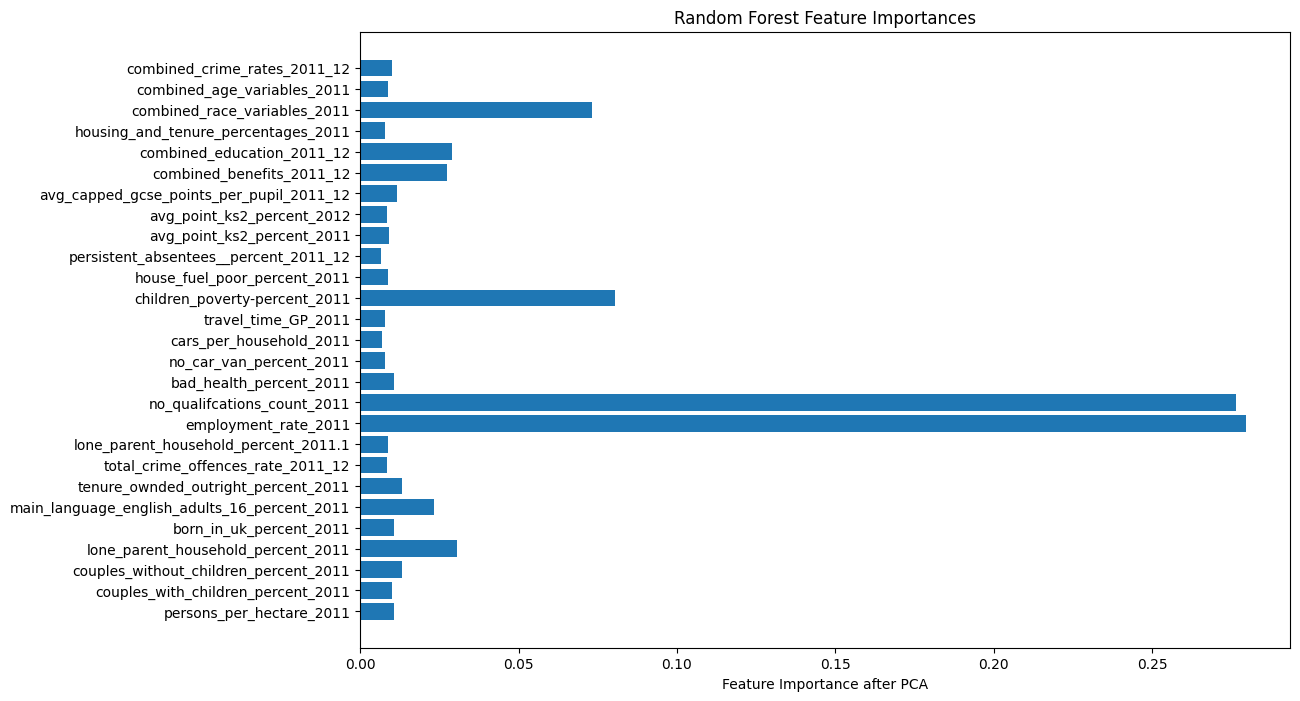

In [43]:
# Visualising Feature Importance with
# A Horizontal Bar Chart
plt.figure(figsize = (12, 8))
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance after PCA')
plt.title('Random Forest Feature Importances')
plt.show()

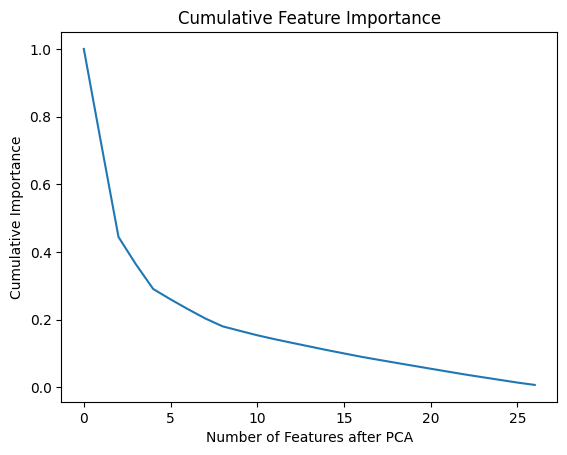

In [44]:
cumulative_importance = np.cumsum(np.sort(rf.feature_importances_))[::-1]
plt.plot(cumulative_importance)
plt.xlabel('Number of Features after PCA')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.show()

## KNN Regression Model

 **1st KNN Model**
 The input configuration is to use all the numeric variables but to leave out the target variable (MSOA income estimate)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [10]:
# Loading the preprocessed dataset
data_path = '../../data/processed/lsoa_census_standardized.csv'
data = pd.read_csv(data_path)

# Selecting only numeric columns for features
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Ensuring that the target column is excluded from features
X = data[numerical_cols].drop(columns=['net_income_after_housing_costs_()'])  # Excluding the target column
y = data['net_income_after_housing_costs_()']

# Identifying the non-numeric columns:
categorical_cols = data.select_dtypes(include=['object']).columns

# Drop any categorical columns from the features set X
X = X.drop(columns=categorical_cols, errors='ignore')

# Splitting data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Training the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors based on optimization
knn.fit(X_train, y_train)

# Making Predictions
y_pred = knn.predict(X_test)

# Save Actual and Predicted Values
evaluation_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

evaluation_data_path = '../../data/processed/evaluation_data.csv'
evaluation_data.to_csv(evaluation_data_path, index=False)
print(f"Evaluation data saved to {evaluation_data_path}")

# Saving the trained KNN model
knn_model_path = '../../model/knn_model.pkl'  # Adjust the path as needed
joblib.dump(knn, knn_model_path)
print(f"Model saved to {knn_model_path}")


Evaluation data saved to ../../data/processed/evaluation_data.csv
Model saved to ../../model/knn_model.pkl


- **2nd KNN Model**
This is for the dataset after 40+ variables were removed due to low feature importance. I want to see how this performs and whether it will enhance the model. 

In [14]:
# Loading the preprocessed dataset
data_path = '../../data/processed/knn_many_removed.csv'
data = pd.read_csv(data_path)

# Selecting only numeric columns for features
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Ensuring that the target column is excluded from features
X = data[numerical_cols].drop(columns=['net_income_after_housing_costs_()'])  # Excluding the target column
y = data['net_income_after_housing_costs_()']

# Identifying the non-numeric columns:
categorical_cols = data.select_dtypes(include=['object']).columns

# Drop any categorical columns from the features set X
X = X.drop(columns=categorical_cols, errors='ignore')

# Splitting data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors based on optimization
knn.fit(X_train, y_train)

# Making Predictions
y_pred = knn.predict(X_test)

# Save Actual and Predicted Values
evaluation_data_2 = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

evaluation_data_path_2 = '../../data/processed/evaluation_data_2.csv'
evaluation_data_2.to_csv(evaluation_data_path_2, index = False)
print(f"Evaluation data saved to {evaluation_data_path_2}")

Evaluation data saved to ../../data/processed/evaluation_data_2.csv


**3rd KNN Model - Feature Importance After Removing the Confidence Intervals**

In [16]:
# Loading the preprocessed dataset
data_path = '../../data/processed/knn_confidence_interval.csv'
data = pd.read_csv(data_path)

# Selecting only numeric columns for features
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Ensuring that the target column is excluded from features
X = data[numerical_cols].drop(columns=['net_income_after_housing_costs_()'])  # Excluding the target column
y = data['net_income_after_housing_costs_()']

# Identifying the non-numeric columns:
categorical_cols = data.select_dtypes(include=['object']).columns

# Drop any categorical columns from the features set X
X = X.drop(columns=categorical_cols, errors='ignore')

# Splitting data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

# Training the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors based on optimization
knn.fit(X_train, y_train)

# Making Predictions
y_pred = knn.predict(X_test)

# Save Actual and Predicted Values
evaluation_data_3 = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

evaluation_data_path_3 = '../../data/processed/evaluation_data_3.csv'
evaluation_data_3.to_csv(evaluation_data_path_3, index = False)
print(f"Evaluation data saved to {evaluation_data_path_3}")

Evaluation data saved to ../../data/processed/evaluation_data_3.csv


**4th KNN Model - Feature Importance After PCA Analysis**
This is where the most of the crime variables were combined, along with most of the educational, race, income support, benefits etc. I noticed that the top two feature importances were closer than all the models before. PCA Analysis looked beneficial in regards to combining variables within the same category. I want to see the evaluation metrics compared with the others, because they perfomed badly compared to the first model (that excluded only the target variable as an input configuration)

In [7]:
# Loading the preprocessed dataset
data_path = '../../data/processed/knn_pca.csv'
data = pd.read_csv(data_path)

# Selecting only numeric columns for features
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Ensuring that the target column is excluded from features
X = data[numerical_cols].drop(columns=['net_income_after_housing_costs_()'])  # Excluding the target column
y = data['net_income_after_housing_costs_()']

# Identifying the non-numeric columns:
categorical_cols = data.select_dtypes(include=['object']).columns

# Drop any categorical columns from the features set X
X = X.drop(columns=categorical_cols, errors='ignore')

# Splitting data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Training the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors based on optimization
knn.fit(X_train, y_train)

# Making Predictions
y_pred = knn.predict(X_test)

# Save Actual and Predicted Values
evaluation_data_4 = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

evaluation_data_path_4 = '../../data/processed/evaluation_data_4.csv'
evaluation_data_4.to_csv(evaluation_data_path_4, index = False)
print(f"Evaluation data saved to {evaluation_data_path_4}")

Evaluation data saved to ../../data/processed/evaluation_data_4.csv


## Model Evaluation of KNN Regression

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

MAE: 0.24892674781770646
RMSE: 0.3313161029192417
R²: 0.8922311017516198


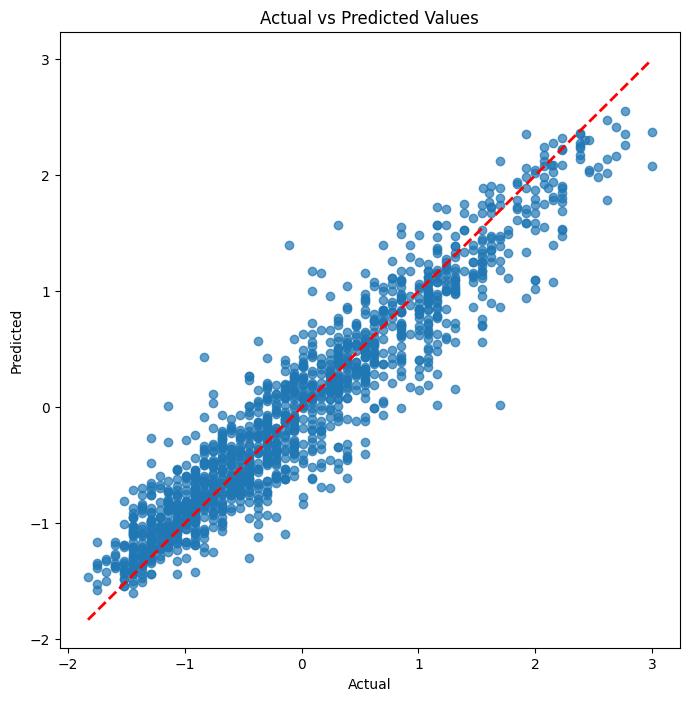

In [3]:
# Loading the results for evaluations
evaluation_data_path = '../../data/processed/evaluation_data.csv'
evaluation_data = pd.read_csv(evaluation_data_path)

# Extracting the actual and predicted Values
y_test = evaluation_data['Actual']
y_pred = evaluation_data['Predicted']

# Evaluating the Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Visualizing Results
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()


This is the scatter graph for the actual mean income estimates and the predicted mean income estimates. I think this is because the confidence intervals were included in the dataset.

**2nd KNN Model**. This is for the dataset after 40+ variables were removed due to low feature importance. I want to see how this performs and whether it will enhance the model.

MAE: 0.37157494260056184
RMSE: 0.5070376653720114
R²: 0.7476003208057866


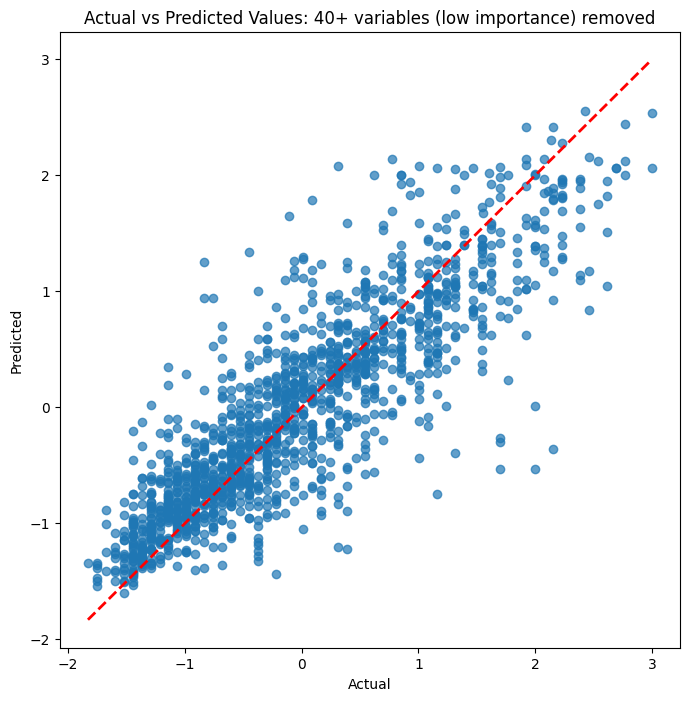

In [9]:
# Loading the results for evaluations
evaluation_data_path_2 = '../../data/processed/evaluation_data_2.csv'
evaluation_data_2 = pd.read_csv(evaluation_data_path_2)

# Extracting the actual and predicted Values
y_test = evaluation_data_2['Actual']
y_pred = evaluation_data_2['Predicted']

# Evaluating the Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Visualizing Results
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values: 40+ variables (low importance) removed')
plt.show()

**3rd KNN Model - Feature Importance After Removing the Confidence Intervals**

MAE: 0.3778629161401336
RMSE: 0.5116140517642452
R²: 0.7430235753244887


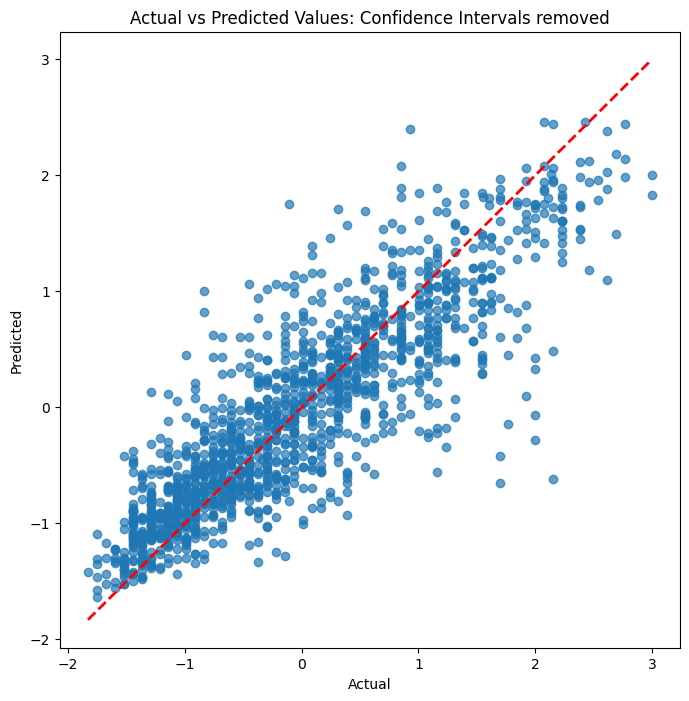

In [12]:
# Loading the results for evaluations
evaluation_data_path_3 = '../../data/processed/evaluation_data_3.csv'
evaluation_data_3 = pd.read_csv(evaluation_data_path_3)

# Extracting the actual and predicted Values
y_test = evaluation_data_3['Actual']
y_pred = evaluation_data_3['Predicted']

# Evaluating the Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Visualizing Results
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values: Confidence Intervals removed')
plt.show()

MAE: 0.4028818222856442
RMSE: 0.536736609303709
R²: 0.7171665371139297


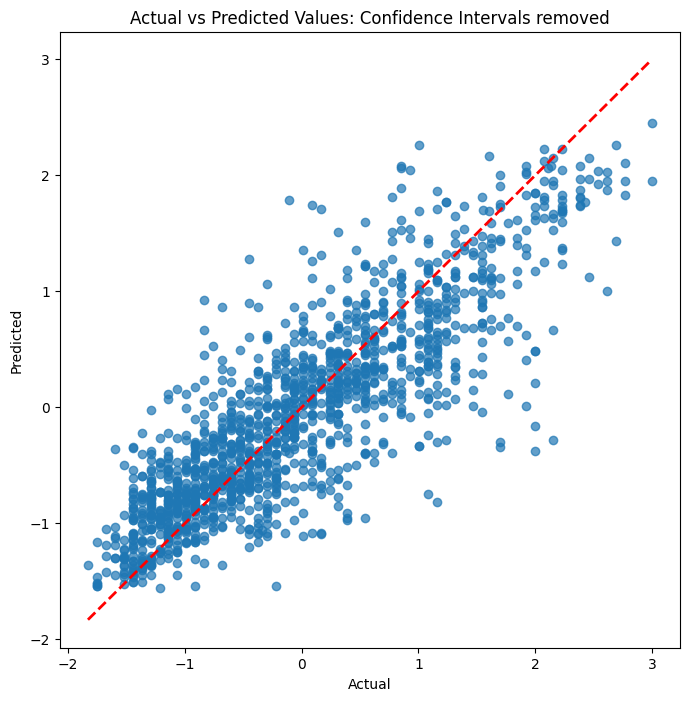

In [6]:
# Loading the results for evaluations
evaluation_data_path_4 = '../../data/processed/evaluation_data_4.csv'
evaluation_data_4 = pd.read_csv(evaluation_data_path_4)

# Extracting the actual and predicted Values
y_test = evaluation_data_4['Actual']
y_pred = evaluation_data_4['Predicted']

# Evaluating the Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Visualizing Results
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values: Confidence Intervals removed')
plt.show()

This was surpising, but the 1st Model that only removed the target variable and kept the confidence intervals, did better significantly.

Model 1 has a relatively low MAE which means that the error was relatively low. The R squared value was really high which indicates that the model was fitting well. 

## Final Model Results - Prediction of LSOA income estimates

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import numpy as np

I am going to do both the training and predictions in the same file for simplicity. 

In [13]:

# These are file paths needed for training and predictions
data_path = '../../data/processed/lsoa_census_standardized.csv'
model_path = '../../model/knn_model.pkl'
scaler_path = '../../model/scaler.pkl'
predictions_path = '../../data/processed/lsoa_income_predictions.csv'

# Loading the preprocessed dataset
data = pd.read_csv(data_path)

# Preparing the data
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
X = data[numerical_cols].drop(columns=['net_income_after_housing_costs_()'])  # Features
y = data['net_income_after_housing_costs_()']  # Target variable

# Splitting data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the model
knn = KNeighborsRegressor(n_neighbors=5)  # You can optimize this parameter
knn.fit(X_train_scaled, y_train)

# Saving the model and scaler for reuse
joblib.dump(knn, model_path)
joblib.dump(scaler, scaler_path)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

# Step 4: Evaluating the Model
y_pred = knn.predict(X_test_scaled)

# Computing the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Evaluation Metrics:\nMAE: {mae}\nRMSE: {rmse}\nR²: {r2}")

# Making Predictions on LSOA Data
# Load LSOA data (assume it's already standardized and the same as `data_path`)
lsoa_data = pd.read_csv(data_path)

# Selecting only features for prediction
lsoa_data_features = lsoa_data[numerical_cols].drop(columns=['net_income_after_housing_costs_()'])

# Scaling the LSOA features using the fitted scaler
lsoa_data_features_scaled = scaler.transform(lsoa_data_features)

# Predicting the income estimates
lsoa_income_predictions = knn.predict(lsoa_data_features_scaled)

# Add predictions to the LSOA dataset
lsoa_data['predicted_income'] = lsoa_income_predictions

# Save predictions to a CSV file
lsoa_data.to_csv(predictions_path, index = False)
print(f"LSOA income predictions saved to {predictions_path}")


Model saved to ../../model/knn_model.pkl
Scaler saved to ../../model/scaler.pkl
Evaluation Metrics:
MAE: 0.24826180775382545
RMSE: 0.32966203674803696
R²: 0.8933044689770794


C:\Users\bretu\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


LSOA income predictions saved to ../../data/processed/lsoa_income_predictions.csv


Due to time constraints, I do not have time to analyse and scrutinise the results. If there was time, I would have used the MSOA-level totals as a baseline for the validation of LSOA net income estimates. I will do a simple visulisation to get an overview of the statistics to see if there are imbalances or outliers (obvious ones of course!). It would have been nice to apply these predictions on the map, but that is why I made a scaler path for future use.

Summary Statistics for Predicted Income:
count    4762.000000
mean       -0.008322
std         0.915489
min        -1.631439
25%        -0.757869
50%        -0.129511
75%         0.590801
max         2.613806
Name: predicted_income, dtype: float64


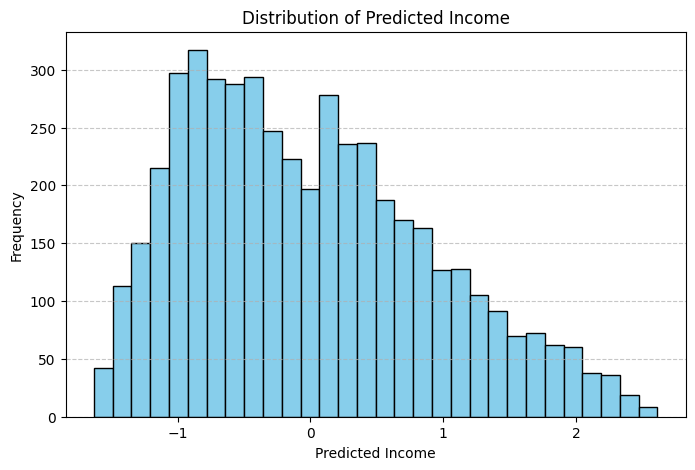

In [19]:
# A quick overview and statistical summary
summary = lsoa_data['predicted_income'].describe()
print("Summary Statistics for Predicted Income:")
print(summary)

# Histogram of predicted incomes
plt.figure(figsize=(8, 5))
plt.hist(lsoa_data['predicted_income'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Income")
plt.xlabel("Predicted Income")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

And yes the figures are still standardised, where 0 is the mean and the values above are the standard deviations. The standard deviation is 0.915 which falls under one standard deviation. There seems to be bimodal nature towards where the mean value is, indicating that there may be two distinct groups, I'm assuming that this could be the gap between the wealthy and the least wealthy.

In [18]:
# Display the head of the ID column and the new predictions column
id_column = lsoa_data.columns[0]  # Assuming the first column acts as an ID
print(lsoa_data[[id_column, 'predicted_income']].head())

   lsoa_code  predicted_income
0  E01000027         -1.018408
1  E01000028         -0.972430
2  E01000029         -0.328747
3  E01000030         -0.803846
4  E01000031         -0.420701


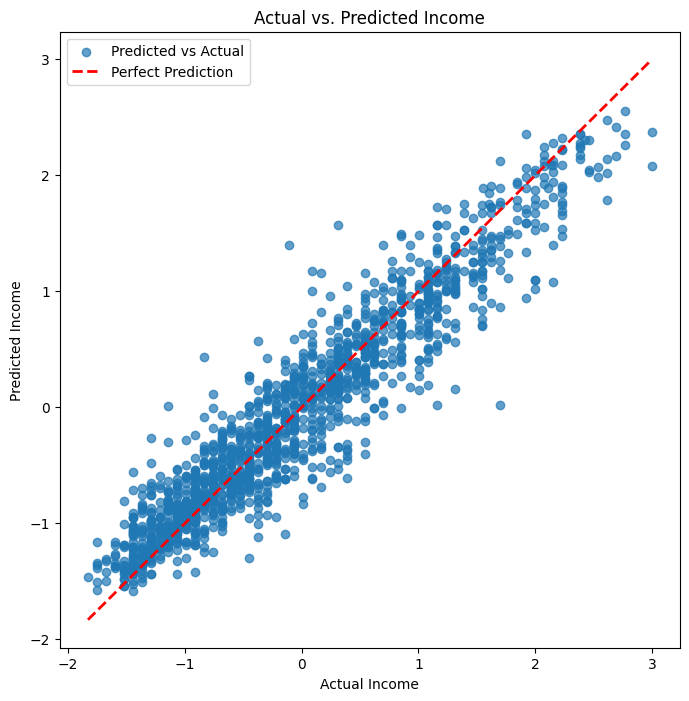

In [16]:
# Scatter plot of actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Income")
plt.ylabel("Predicted Income")
plt.title("Actual vs. Predicted Income")
plt.legend()
plt.show()

This is the same scatter plot for the training and evaluation of the chosen model.